New from v13 (AN_v2):
 - Save B pT nad eta as well
 - D** lineshape (DstPi and DstPiPi)
 - New backgrouns samples: D** Tau
 
New from v14:
 - pT uncertainty for B+ as well
 - Poly B pT uncertainty
 - Possibility of running with BLPR FF
 - DstPiPi wider (200 MeV MC)
 - Mu pT corrections
 
To do:
 - Tracking SF (to do)
 - Add combinatorial and fake from data template

In [1]:
use_real_data = True
blinded_fit = True

category = ['low', 'mid', 'high', 'single'][0]
useMVA = [False, 'v0', 'v1'][0]
schemeFF = ['CLN', 'BLPR', 'NoFF'][0]
card_name = 'v16'

In [2]:
useMCstats = True

runCombine = True
runScanOnly = False
runBias = False
runFitDiagnostics = True
runImpacts = False
runGoF = False

# Import

In [3]:
import sys, os, pickle, time
from glob import glob
sys.path.append('../lib')
sys.path.append('../analysis')
from categoriesDef import categories as categoriesDef
import itertools
import commands
from prettytable import PrettyTable
import json, yaml
from IPython.display import IFrame, Image, display

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from array import array

import uproot as ur
import ROOT as rt
rt.gErrorIgnoreLevel = rt.kError
rt.RooMsgService.instance().setGlobalKillBelow(rt.RooFit.ERROR)
import root_numpy as rtnp

from analysis_utilities import drawOnCMSCanvas, getEff, DSetLoader
from pT_calibration_reader import pTCalReader
from histo_utilities import create_TH1D, create_TH2D, std_color_list
from gridVarQ2Plot import plot_gridVarQ2, plot_SingleCategory, getControlXtitle, getControlSideText
from progressBar import ProgressBar
from lumi_utilities import getLumiByTrigger
from combine_utilities import getUncertaintyFromLimitTree, dumpDiffNuisances, stringJubCustomizationCaltechT2, loadHisto4CombineFromRoot

import CMS_lumi, tdrstyle
tdrstyle.setTDRStyle()
CMS_lumi.writeExtraText = 1

if use_real_data:
    CMS_lumi.extraText = "     Preliminary"
else:
    CMS_lumi.extraText = "     Simulation Preliminary"

donotdelete = []

Welcome to JupyROOT 6.12/07


In [5]:
card_name += category + '_' + schemeFF
if useMVA:
    card_name += '_MVA'+useMVA
if not use_real_data: 
    card_name += '_Asimov'
if blinded_fit: 
    card_name += '_blinded'
if not useMCstats: 
    card_name += '_NoMCstats'
outdir = 'results/' + card_name
if not os.path.isdir(outdir):
    os.system('mkdir -p ' + outdir + '/fig')
card_location = 'cards/{}.txt'.format(card_name)
histo_file_dir = '/storage/user/ocerri/BPhysics/data/_root/histos4combine/'

In [6]:
cat = categoriesDef[category]
binning = {'q2': array('d', [-2, 2.5, 6, 9.4, 12])}
SM_RDst = 0.295
expectedLumi = {'low':6.4, 'mid':20.7, 'high':26.4, 'single':6.} #fb^-1
lumi_tot = expectedLumi[category]

In [7]:
FreeParFF = {
   'CLN': ['R0', 'eig1', 'eig2', 'eig3'],
   'BLPR': ['eig1', 'eig2', 'eig3', 'eig4', 'eig5', 'eig6'],
   'NoFF': []
}[schemeFF]

# Create histograms

## Load the datasets

In [8]:
#They all have to be produced with the same pileup
MCsample = {
'tau' : DSetLoader('B0_TauNuDmst_PUc0'),
'mu' : DSetLoader('B0_MuNuDmst_PUc0'),
'DstmD0' : DSetLoader('B0_DstmD0_PUc0'),
'DstmDp' : DSetLoader('B0_DstmDp_PUc0'),
'DstmDsp' : DSetLoader('B0_DstmDsp_PUc0'),
'BpDstmHc' : DSetLoader('Bp_DstmHc_PUc0'),
'BmDstmHc' : DSetLoader('Bm_DstmHc_PUc0'),
'antiB0DstmHc' : DSetLoader('antiB0_DstmHc_PUc0'),
'DstPip' : DSetLoader('Bp_MuNuDstst_Pip_PUc0'),
'DstPi0' : DSetLoader('B0_MuNuDstst_Pi0_PUc0'),
'DstPipPi0' : DSetLoader('Bp_MuNuDstst_PipPi0_PUc0'),
'DstPipPim' : DSetLoader('B0_MuNuDstst_PipPim_PUc0'),
# 'DstPipPi0' : DSetLoader('Bp_MuNuDstPipPi0_PUc0'),
# 'DstPipPim' : DSetLoader('B0_MuNuDstPipPim_PUc0'),
'DstPi0Pi0' : DSetLoader('B0_MuNuDstst_Pi0Pi0_PUc0'),
'TauDstPi0' : DSetLoader('B0_TauNuDstst_Pi0_PUc0'),
'TauDstPip' : DSetLoader('Bp_TauNuDstst_Pip_PUc0')
}
processOrder = ['tau', 'mu', 
                'DstPip','DstPi0',
                'DstPipPi0','DstPipPim','DstPi0Pi0',
                'TauDstPi0', 'TauDstPip',
                'DstmDsp','DstmD0','DstmDp',
                'BpDstmHc','BmDstmHc','antiB0DstmHc']
dSet = {}
dSetTkSide = {}
for n, s in MCsample.iteritems():
    if not n in processOrder: raise
    dSet[n] = pd.DataFrame(rtnp.root2array(s.skimmed_dir + '/{}_corr.root'.format(cat.name)))
    dSetTkSide[n] = rtnp.root2array(s.skimmed_dir + '/{}_trkCtrl_corr.root'.format(cat.name))

In [9]:
SamplesB0 = ['mu', 'tau', 
             'DstmD0', 'DstmDp', 'DstmDsp', 
             'antiB0DstmHc', 
             'DstPi0', 
             'DstPipPim', 'DstPi0Pi0', 
             'TauDstPi0'
            ]

SamplesBp = ['BpDstmHc', 'BmDstmHc', 
             'DstPip', 
             'DstPipPi0', 
             'TauDstPip'
            ]

In [10]:
if use_real_data:
    creation_date = '201101'
    locRD = '../data/cmsRD/skimmed/B2DstMu_B0_{}_{}'.format(creation_date, cat.name)
    dSet['data'] = pd.DataFrame(rtnp.root2array(locRD + '_corr.root'))
    dSetTkSide['data'] = pd.DataFrame(rtnp.root2array(locRD + '_trkCtrl_corr.root'))
    dataDir = '../data/cmsRD'
    datasets_loc = glob(dataDir + '/ParkingBPH*/*RDntuplizer_B2DstMu_{}_CAND.root'.format(creation_date))
    lumi_tot = getLumiByTrigger(datasets_loc, cat.trg, verbose=True)
    if lumi_tot == 0:
        lumi_tot = {'Low':6.4, 'Mid':20., 'High':26.}[cat.name]
        print lumi_tot
    CMS_lumi.integrated_lumi = lumi_tot
    
    #Add anti-B0 data
    creation_date = '201122'
    locRD = '../data/cmsRD/skimmed/B2DstMu_antiB0_{}_{}'.format(creation_date, cat.name)
    aux = pd.DataFrame(rtnp.root2array(locRD + '_corr.root'))
    dSet['data'] = pd.concat([dSet['data'], aux])
    auxTk = pd.DataFrame(rtnp.root2array(locRD + '_trkCtrl_corr.root'))
    dSetTkSide['data'] = pd.concat([dSetTkSide['data'], auxTk])

Run2018D-05May2019promptD-v1_RDntuplizer_B2DstMu_201101
HLT_Mu7_IP4_part2_v2 1.28
Run2018D-05May2019promptD-v1_RDntuplizer_B2DstMu_201101
HLT_Mu7_IP4_part1_v2 1.28
Run2018D-05May2019promptD-v1_RDntuplizer_B2DstMu_201101
HLT_Mu7_IP4_part4_v2 1.28
Run2018D-05May2019promptD-v1_RDntuplizer_B2DstMu_201101
HLT_Mu7_IP4_part3_v2 1.28
Run2018D-05May2019promptD-v1_RDntuplizer_B2DstMu_201101
HLT_Mu7_IP4_part0_v2 1.27
Total lumi: 6.39 fb^-1


## Load calibrations

Pileup

In [11]:
from pileup_utilities import pileupReweighter
puReweighter = pileupReweighter(MCsample['mu'].skimmed_dir + '/{}_corr.root'.format(cat.name), cat)

Branching fraction

In [12]:
decayBR = pickle.load(open('../data/forcedDecayChannelsFactors.pickle', 'rb'))

Trigger scale factor

In [13]:
loc = '../data/calibration/triggerScaleFactors/'
fTriggerSF = rt.TFile.Open(loc + 'HLT_' + cat.trg + '_SF_v3.root', 'READ')
hTriggerSF = fTriggerSF.Get('hSF_HLT_' + cat.trg)

In [14]:
def computeTrgSF(ds, selection=None):
    trgSF = np.ones_like(ds['q2'])
    trgSFUnc = np.zeros_like(ds['q2'])
    ptmax = hTriggerSF.GetXaxis().GetXmax() - 0.01
    ipmax = hTriggerSF.GetYaxis().GetXmax() - 0.01
    etamax = hTriggerSF.GetZaxis().GetXmax() - 0.01
    x = np.column_stack((ds['mu_pt'], ds['mu_eta'], ds['mu_sigdxy']))
    if not selection is None:
        x = x[selection]
    for i, (pt, eta, ip) in enumerate(x):
        ix = hTriggerSF.GetXaxis().FindBin(min(ptmax, pt))
        iy = hTriggerSF.GetYaxis().FindBin(min(ipmax, ip))
        iz = hTriggerSF.GetZaxis().FindBin(min(etamax, np.abs(eta)))
        trgSF[i] = hTriggerSF.GetBinContent(ix, iy, iz)
        ib = hTriggerSF.GetBin(ix, iy, iz)
        trgSFUnc[i] = hTriggerSF.GetBinError(ib)
        if trgSF[i] == 0:
            print pt, ip, np.abs(eta)
            raise
    # Divide them for the weight so later you can simply multiply back to get the value
    up = 1 + trgSFUnc/trgSF
    down = 1 - trgSFUnc/trgSF
    return trgSF, up, down

Muon ID scale factors

In [15]:
fMuonIDSF = rt.TFile.Open('../data/calibration/muonIDscaleFactors/Run2018ABCD_SF_MuonID_Jpsi.root', 'READ')
hMuonIDSF = fMuonIDSF.Get('NUM_SoftID_DEN_genTracks_pt_abseta')

In [16]:
def computeMuonIDSF(ds, selection=None):
    muonSF = np.ones_like(ds['q2'])
    muonSFUnc = np.zeros_like(ds['q2'])
    ptmax = hMuonIDSF.GetXaxis().GetXmax() - 0.01
    etamax = hMuonIDSF.GetYaxis().GetXmax() - 0.01
    x = np.column_stack((ds['MC_mu_pt'], ds['MC_mu_eta']))
    if not selection is None:
        x = x[selection]
    for i, (pt, eta) in enumerate(x):
        ix = hMuonIDSF.GetXaxis().FindBin(min(pt, ptmax))
        if ix == 0: ix = 1 #Remove underflows (Meaning that the MC matching failed)
        iy = hMuonIDSF.GetYaxis().FindBin(min(np.abs(eta), etamax))
        muonSF[i] = hMuonIDSF.GetBinContent(ix, iy)
        muonSFUnc[i] = hMuonIDSF.GetBinError(hMuonIDSF.GetBin(ix, iy))
        if muonSF[i] == 0:
            print pt, eta
            print ix, iy
            raise
    up = 1 + muonSFUnc/muonSF
    down = 1 - muonSFUnc/muonSF
#     print np.column_stack((muonSF, up, down, muonSF*up, muonSF*down))
#     raise
    return muonSF, up, down

B transverse momentum calibration

In [17]:
aux = 'Low' if category == 'single' else cat.name
cal_pT_B0 = pTCalReader(calibration_file='../data/calibration/B0pTspectrum/polyCoeffWeights_{}.pkl'.format(aux))
cal_pT_Bp = pTCalReader(calibration_file='../data/calibration/Bcharged_pTspectrum/pwWeights_{}.txt'.format(aux))
cal_pT_mu = pTCalReader(calibration_file='../data/calibration/MuonPtSpectrum/polyCoeffWeights_{}.pkl'.format(aux))

In [18]:
def computePtWeights(ds, var, tag, cal_pT):
    if cal_pT.kind == 'poly':
        # The denominator (sum of weights) for this weights is not known but it cancel out in the ratio
        w = cal_pT.getWeights(ds[var], shape=0)
        if np.sum(w==0):
            print np.sum(w==0)
            raise

        varDic = {}
        for iShape in range(1, cal_pT.nVar+1):
            varDic[tag+'_lam{}Down'.format(iShape)] = cal_pT.getWeights(ds[var], shape=-iShape)/w
            varDic[tag+'_lam{}Up'.format(iShape)] = cal_pT.getWeights(ds[var], shape=+iShape)/w
        return w, varDic
    elif cal_pT.kind == 'ratio':
        w = cal_pT.f['C'](ds[var])
        if np.sum(w==0):
            print np.sum(w==0)
            raise
        up = cal_pT.f['Up'](ds[var])/w
        down = cal_pT.f['Down'](ds[var])/w
        return w, up, down
    else:
        print 'Unknown calibration'
        raise

In [19]:
pWeightsEta = pickle.load(open('../data/calibration/B0pTspectrum/etaWeights_poly_{}.p'.format(cat.name), 'rb'))
def computeB0etaWeights(ds):
    w = np.polyval(p=pWeightsEta, x=ds['B_eta'])
    return np.clip(w, a_min=0.5, a_max=1.5)

In [20]:
def computeBrVarWeights(ds, selItems={}, relScale=0.2, keepNorm=False):
    sel = np.ones_like(ds['mu_pt']).astype(np.bool)
    for var, val in selItems.iteritems():
        sel = np.logical_and(ds[var].astype(np.int) == val, sel)
    w = np.ones_like(sel)
    up = np.where(sel, 1.+relScale, 1.)
    down = np.where(sel, max(0, 1.-relScale), 1.)
    if keepNorm:
        up = float(up.shape[0])/np.sum(up)
        down = float(down.shape[0])/np.sum(down)
    return w, up, down

In [21]:
def computeWidthVarWeights(ds, selItems=[], #pdgId, mass, Gamma
                           relScale=0.1): #Gamma modification factor
    up = np.ones_like(ds['mu_pt'])
    down = np.ones_like(ds['mu_pt'])
    for pdgId, mass, gamma in selItems:
        print pdgId, mass, gamma
        gUp = gamma*(1+relScale)
        gDown = gamma*(1-relScale)

        dx2 = np.clip(np.square(ds['MC_MassCharmedBDaughter'] - mass), 0, 9*(gamma**2))
        wUp = ((dx2 + gamma**2)*gUp)/(gamma*(dx2 + gUp**2))
        wDown = ((dx2 + gamma**2)*gDown)/(gamma*(dx2 + gDown**2))
        
        sel = np.abs(ds['MC_DstMotherPdgId'].astype(np.int)) == np.abs(pdgId)
        up = np.where(sel, wUp, up)
        down = np.where(sel, wDown, down)
        
    w = np.ones_like(sel)    
    return w, up, down

In [22]:
def computeTksPVweights(ds, relScale=0.05, centralVal=0.39/0.10):
    selPdgID0 = np.logical_and(np.abs(ds['MC_tkMotherPdgId_0']) < 6, ds['MC_tkMotherPdgId_0'] != 0)
    selPdgID0 = np.logical_or(selPdgID0, ds['MC_tkMotherPdgId_0']==2212)
    selPdgID0 = np.logical_and(selPdgID0, ds['MC_tkFlag_0'] == 1)
    selPdgID1 = np.logical_and(np.abs(ds['MC_tkMotherPdgId_1']) < 6, ds['MC_tkMotherPdgId_1'] != 0)
    selPdgID1 = np.logical_or(selPdgID1, ds['MC_tkMotherPdgId_1']==2212)
    selPdgID1 = np.logical_and( selPdgID1, ds['MC_tkFlag_1'] == 1)
    exponent = selPdgID0.astype(np.int) + selPdgID1.astype(np.int)
    w = np.power(centralVal, exponent)
    up = np.power(centralVal*(1+relScale), exponent)/w
    down = np.power(centralVal*(1-relScale), exponent)/w
    return w, up, down

MVA

In [23]:
if useMVA:
    fname = '../plot_scripts/kinObsMVA/clfGBC_tauVall_{}{}.p'.format(useMVA, cat.name)
    clfGBC = pickle.load(open(fname, 'rb'))
    
    def computeVarMVA(ds):
        if useMVA == 'v0':
            aux = np.column_stack((ds['q2'], ds['Est_mu'], ds['M2_miss']))
        elif useMVA == 'v1':
            ds['pt_vis'] = ds['B_pt']*ds['mass_D0pismu']/5.27963
            aux = np.column_stack((ds['q2'], ds['Est_mu'], ds['M2_miss'], 
                                   ds['pt_vis'], ds['mass_D0pismu'],
                                   ds['B_eta']
                                         ))
        else: raise
        p = clfGBC.predict_proba(aux)
        return p[:,1]

## Create MC histograms

In [24]:
histo = {}
eventCountingStr = {}
RDoMC_normRatio = 6 # Difference in Pythia prediction between Hard and Soft QCD production
RDoMC_normRatio *= 2 #Both charge signs

### Signal region

In [25]:
binning = {
    'M2_miss' : [
        array('d', [-2.5] + list(np.arange(-1.8, -0.2, 0.4)) + [-0.2, 0., 0.2, 0.6, 8] ),
        array('d', [-2.5] + list(np.arange(-1.8, -0.1, 0.4)) + [-0.1, 0.0, 0.1, 0.2, 0.3] + list(np.arange(0.4, 3.0, 0.4)) + [8] ),
        array('d', [-2.5] + list(np.arange(-1.8, 5.6, 0.4)) + [8] ),
        array('d', [-2.5] + list(np.arange(-1.8, 7.6, 0.4)) + [8] ),
    ],
    'Est_mu'  : [
        array('d', [0.3] + list(np.arange(0.5, 2.4, 0.05)) + [2.5] ),
        array('d', [0.3] + list(np.arange(0.5, 2.5, 0.05)) + [2.5] ),
        array('d', [0.3] + list(np.arange(0.5, 2.5, 0.1)) + [2.5] ),
        [22, 0.3, 2.500],
    ],
}

binning_2D = [
    [
        array('d', [-2.5] + list(np.arange(-1.8, -0.2, 0.4)) + [-0.2, 0., 0.2, 0.6, 8] ),
#         array('d', [0.3] + list(np.arange(0.7, 2.3, 0.5)) + [2.5] )
        array('d', [0.3] + list(np.arange(0.7, 2.3, 0.3)) + [2.5] )
    ],
    [
        array('d', [-2.5] + list(np.arange(-1.8, 3.0, 0.4)) + [8] ),
#         array('d', [0.3] + list(np.arange(0.7, 2.5, 0.5)) + [2.5] )
        array('d', [0.3] + list(np.arange(0.7, 2.5, 0.3)) + [2.5] )
    ],
    [
        array('d', [-2.5] + list(np.arange(-1.8, 5.6, 0.4)) + [8] ),
        array('d', [0.3] + list(np.arange(0.5, 2.5, 0.3)) + [2.5] )
    ],
    [
        array('d', [-2.5] + list(np.arange(-1.8, 7.6, 0.4)) + [8] ),
        array('d', list(np.linspace(0.3, 2.5, 11)) )
    ]
    
]

binning['q2'] = array('d', [-2, 2.5, 6, 9.4, 12])
binning['B_pt'] = {'low': array('d', list(np.arange(10, 75, 2)) ),
                   'mid': array('d', list(np.arange(14, 90, 2)) ),
                   'high': array('d', list(np.arange(18, 110, 2)))
                  }[category]
binning['B_eta'] = array('d', list(np.arange(-1.9, 1.91, 0.05)) )

if use_real_data:
    binning['MVA'] = array('d', list(np.arange(0., 0.51, 0.03)))
else:
    binning['MVA'] = array('d', list(np.arange(0., 0.83, 0.02)))

In [26]:
totalCounting = [0,0]
for n in processOrder: 
    ds = dSet[n]
    if n == 'data': continue
    print '\n----------->', n, '<-------------'
    sMC = MCsample[n]
    
    nTotSelected = ds['q2'].shape[0]
    print 'N tot selected: {:.1f}k'.format(1e-3*nTotSelected)
    totalCounting[1] += 1e-3*nTotSelected
    nGenExp = sMC.effMCgen['xsec'][0] * lumi_tot * RDoMC_normRatio
    eff = [1, 0]
    for f, df in [sMC.effMCgen['effGEN'], decayBR[n], sMC.effCand['effCAND'], sMC.getSkimEff(cat.name+'_corr')]:
        eff[0] *= f
        eff[1] += np.square(df/f)
    eff[1] = eff[0] * np.sqrt(eff[1])
    nTotExp = nGenExp*eff[0]
    print 'N tot expected (before weights): {:.2f}k'.format(1e-3*nTotExp)
    
    wVar = {}
    weights = {}
    
    print 'Including pileup reweighting'
    weights['pileup'] = puReweighter.weightsPileupMC[ds['N_vtx'].astype(np.int)]
    print 'Including trigger corrections'
    weights['trg{}SF'.format(cat.trg)], wVar['trg{}SFUp'.format(cat.trg)], wVar['trg{}SFDown'.format(cat.trg)] = computeTrgSF(ds)
#     weights['trg{}SF'.format(cat.trg)], _, _ = computeTrgSF(ds)
    print 'Including muon ID corrections'
#     weights['muonIdSF'], wVar['muonIdSFUp'], wVar['muonIdSFDown'] = computeMuonIDSF(ds)
    weights['muonIdSF'], _, _ = computeMuonIDSF(ds)
    print 'Including muon pT corrections'
    weights['MuPt'], auxVarDic = computePtWeights(ds, 'mu_pt', 'MuPt', cal_pT_mu)
    wVar.update(auxVarDic)
    
    weights['etaB'] = computeB0etaWeights(ds)
    if n in SamplesB0:
        print 'Including B0 pT corrections'
        weights['B0pT'], auxVarDic = computePtWeights(ds, 'MC_B_pt', 'B0pT', cal_pT_B0)
        wVar.update(auxVarDic)
    if n in SamplesBp:
        print 'Including B +/- pT corrections'
        weights['BpPt'], wVar['BpPtUp'], wVar['BpPtDown'] = computePtWeights(ds, 'MC_B_pt', None, cal_pT_Bp)
    # Hammer corrections to the FF
    if n in ['mu', 'tau'] and schemeFF != 'NoFF':
        print 'Including FF corrections (Hammer)'
        weights['B2DstFF'] = ds['wh_'+schemeFF+'Central']*sMC.effCand['rate_den']/sMC.effCand['rate_'+schemeFF+'Central']
        for nPar in FreeParFF:
            for var in ['Up', 'Down']:
                tag = schemeFF + nPar + var
                wVar['B2Dst'+tag] = ds['wh_'+tag]/ds['wh_'+schemeFF+'Central']
                wVar['B2Dst'+tag] *= sMC.effCand['rate_'+schemeFF+'Central']/sMC.effCand['rate_' + tag]
    #Dstst resonance mix
    if n == 'DstPip' or n =='TauDstPip':
        _, wVar['fDststWideUp'], wVar['fDststWideDown'] = computeBrVarWeights(ds, {'MC_munuSisterPdgId': -20423}, 0.6/2.7, keepNorm=True) #Gamma 14 pdg 2020
        widthMods = [
            [10423, 2.422, 0.020],
            [20423, 2.445, 0.250],
            [425, 2.461, 0.043],
        ]
#         _, wVar['DstPipWidthUp'], wVar['DstPipWidthDown'] = computeWidthVarWeights(ds, selItems=widthMods, relScale=0.15)
        _, wVar['D2420_10WidthUp'], wVar['D2420_10WidthDown'] = computeWidthVarWeights(ds, selItems=[[10423, 2.422, 0.020]], relScale=0.15)
        _, wVar['D2430_10WidthUp'], wVar['D2430_10WidthDown'] = computeWidthVarWeights(ds, selItems=[[20423, 2.445, 0.250]], relScale=0.1)
        _, wVar['D2460_1StWidthUp'], wVar['D2460_1StWidthDown'] = computeWidthVarWeights(ds, selItems=[[425, 2.461, 0.043]], relScale=0.15)
    if n == 'DstPipPim' or n == 'DstPi0Pi0':
        widthMods = [[100413, 2.640, 0.200]]
        _, wVar['DstPiPiWidthUp'], wVar['DstPiPiWidthDown'] = computeWidthVarWeights(ds, selItems=widthMods, relScale=0.1)
    #Hc mix variations
    if n == 'DstmD0':
        _, wVar['BrB02DstD0KpUp'], wVar['BrB02DstD0KpDown'] = computeBrVarWeights(ds, {'MC_DstSisterPdgId_heavy': 421, 'MC_DstSisterPdgId_light': 321}, 0.21/2.47) #Gamma 169 pdg 2020
        _, wVar['BrB02DstD0KstpUp'], wVar['BrB02DstD0KstpDown'] = computeBrVarWeights(ds, {'MC_DstSisterPdgId_heavy': 421, 'MC_DstSisterPdgId_light': 323}, 0.5) # Guess
        _, wVar['BrB02DstDst0KpUp'], wVar['BrB02DstDst0KpDown'] = computeBrVarWeights(ds, {'MC_DstSisterPdgId_heavy': 423, 'MC_DstSisterPdgId_light': 321}, 0.09/1.06) #Gamma 170 pdg 2020
        _, wVar['BrB02DstDst0KstpUp'], wVar['BrB02DstDst0KstpDown'] = computeBrVarWeights(ds, {'MC_DstSisterPdgId_heavy': 423, 'MC_DstSisterPdgId_light': 323}, 0.5) # Guess
        _, wVar['BrB02DstDstpK0Up'], wVar['BrB02DstDstpK0Down'] = computeBrVarWeights(ds, {'MC_DstSisterPdgId_heavy': 413, 'MC_DstSisterPdgId_light': 311}, 0.5/5.3) #Gamma 173 pdg 2020
        _, wVar['BrB02DstDstpKst0Up'], wVar['BrB02DstDstpKst0Down'] = computeBrVarWeights(ds, {'MC_DstSisterPdgId_heavy': 413, 'MC_DstSisterPdgId_light': 313}, 0.5) # Guess
    if n == 'DstmDp':
        _, wVar['BrB02DstDpK0Up'], wVar['BrB02DstDpK0Down'] = computeBrVarWeights(ds, {'MC_DstSisterPdgId_heavy': 411, 'MC_DstSisterPdgId_light': 311}, 0.5/3.2) #Gamma 172 pdg 2020
        _, wVar['BrB02DstDpKst0Up'], wVar['BrB02DstDpKst0Down'] = computeBrVarWeights(ds, {'MC_DstSisterPdgId_heavy': 411, 'MC_DstSisterPdgId_light': 313}, 0.5) # Guess
        _, wVar['BrB02DstDstpK0Up'], wVar['BrB02DstDstpK0Down'] = computeBrVarWeights(ds, {'MC_DstSisterPdgId_heavy': 413, 'MC_DstSisterPdgId_light': 311}, 0.2/2.7) #Gamma 173 pdg 2020
        _, wVar['BrB02DstDstpKst0Up'], wVar['BrB02DstDstpKst0Down'] = computeBrVarWeights(ds, {'MC_DstSisterPdgId_heavy': 413, 'MC_DstSisterPdgId_light': 313}, 0.5) # Guess
    if n == 'DstmDsp':
        _, wVar['BrB02DstDsUp'], wVar['BrB02DstDsDown'] = computeBrVarWeights(ds, {'MC_DstSisterPdgId_heavy': 431}, 1.1/8.0) #Gamma 83 pdg 2020
        _, wVar['BrB02DstDsstUp'], wVar['BrB02DstDsstDown'] = computeBrVarWeights(ds, {'MC_DstSisterPdgId_heavy': 433}, .14/1.77) #Gamma 85 pdg 2020
        _, wVar['BrB02DstDs0stUp'], wVar['BrB02DstDs0stDown'] = computeBrVarWeights(ds, {'MC_DstSisterPdgId_heavy': 10431}, .6/1.5) #Gamma 95 pdg 2020
    
    print 'Computing total weights'
    weightsCentral = np.ones_like(ds['q2'])
    for w in weights.values(): 
        weightsCentral *= w
    print 'N tot expected (after weights): {:.3f}k'.format(1e-3*nTotExp*np.sum(weightsCentral)/nTotSelected)
    totalCounting[0] += 1e-3*nTotExp*np.sum(weightsCentral)/nTotSelected
    evCountStr = '{:.2f} ({:.2f})'.format(1e-3*nTotExp*np.sum(weightsCentral)/nTotSelected, 1e-3*nTotSelected)
    eventCountingStr[n] = evCountStr
    wVar[''] = np.ones_like(weightsCentral)
    
    
    if useMVA:
        print 'Evaluating MVA'
        if not 'MVA' in histo.keys():
            histo['MVA'] = {}
        sMVA = computeVarMVA(ds)
        for name_wVar, v_wVar in wVar.iteritems():
                h_name = n
                if not name_wVar == '':
                    h_name += '__' + name_wVar
                w = weightsCentral*v_wVar
                scale = nTotExp/nTotSelected
                histo['MVA'][h_name] = create_TH1D(sMVA, name=h_name, weights=w, scale_histo=scale,
                                                   binning=binning['MVA'], opt='underflow,overflow')
    
    for i_q2 in range(len(binning['q2'])-1):
        q2_l = binning['q2'][i_q2]
        q2_h = binning['q2'][i_q2 + 1]
        sel_q2 = np.logical_and(ds['q2'] > q2_l, ds['q2'] <= q2_h)
        name2D = 'h2D_q2bin'+str(i_q2)
        if not name2D in histo.keys():
                histo[name2D] = {}
        for var in ['M2_miss', 'Est_mu']:
            cat_name = var+'_q2bin'+str(i_q2)
            
            if not cat_name in histo.keys():
                histo[cat_name] = {}
            
            for name_wVar, v_wVar in wVar.iteritems():
                h_name = n
                if not name_wVar == '':
                    h_name += '__' + name_wVar
                w = weightsCentral*v_wVar
                scale = nTotExp/nTotSelected
                histo[cat_name][h_name] = create_TH1D(
                                                      ds[var][sel_q2], 
                                                      name=h_name, title=h_name, 
                                                      binning=binning[var][i_q2], 
                                                      opt='underflow,overflow',
                                                      weights=w[sel_q2], scale_histo=scale,
                                                      )
                if not var == 'M2_miss': 
                    continue
                auxS = np.column_stack((ds['M2_miss'][sel_q2], ds['Est_mu'][sel_q2]))
                histo[name2D][h_name] = create_TH2D(
                                                      auxS, 
                                                      name=h_name, title=h_name, 
                                                      binning=binning_2D[i_q2],
                                                      weights=w[sel_q2], scale_histo=scale,
                                                      )
    for var in ['B_pt', 'B_eta']:
        if not var in histo.keys():
            histo[var] = {}          
        for name_wVar, v_wVar in wVar.iteritems():
            h_name = n
            if not name_wVar == '':
                h_name += '__' + name_wVar
            w = weightsCentral*v_wVar
            scale = nTotExp/nTotSelected
            histo[var][h_name] = create_TH1D(ds[var], name=h_name, weights=w, scale_histo=scale,
                                                binning=binning[var], opt='underflow,overflow')
                
                
evCountStr = '{:.1f} ({:.1f})'.format(*totalCounting)
eventCountingStr['tot'] = evCountStr


-----------> tau <-------------
N tot selected: 64.7k
N tot expected (before weights): 29.38k
Including pileup reweighting
Including trigger corrections
Including muon ID corrections
Including muon pT corrections
Including B0 pT corrections
Including FF corrections (Hammer)
Computing total weights
N tot expected (after weights): 33.727k

-----------> mu <-------------
N tot selected: 1000.1k
N tot expected (before weights): 289.49k
Including pileup reweighting
Including trigger corrections
Including muon ID corrections
Including muon pT corrections
Including B0 pT corrections
Including FF corrections (Hammer)
Computing total weights
N tot expected (after weights): 311.064k

-----------> DstPip <-------------
N tot selected: 38.7k
N tot expected (before weights): 9.67k
Including pileup reweighting
Including trigger corrections
Including muon ID corrections
Including muon pT corrections
Including B +/- pT corrections
10423 2.422 0.02
20423 2.445 0.25
425 2.461 0.043
Computing total weig

Dropped bins: 3
Expected dropped candidates: 0.0
Dropped bins: 17
Expected dropped candidates: 2.81851320498
Dropped bins: 70
Expected dropped candidates: 4.30652504338
Dropped bins: 171
Expected dropped candidates: 5.68030515409
Considered bins: [60, 74, 90, 79]


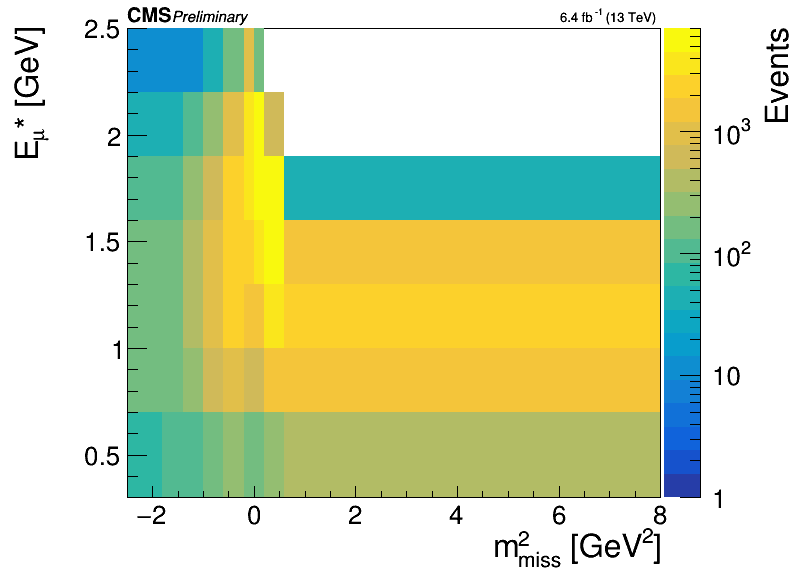

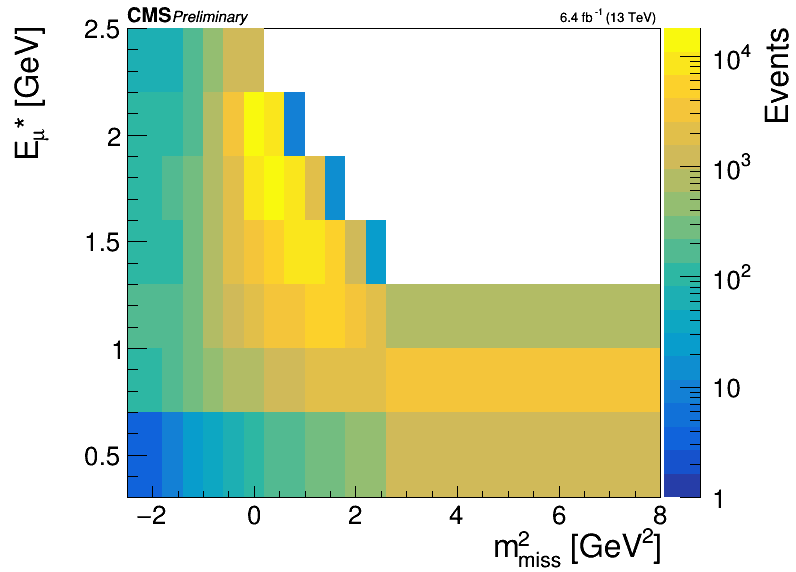

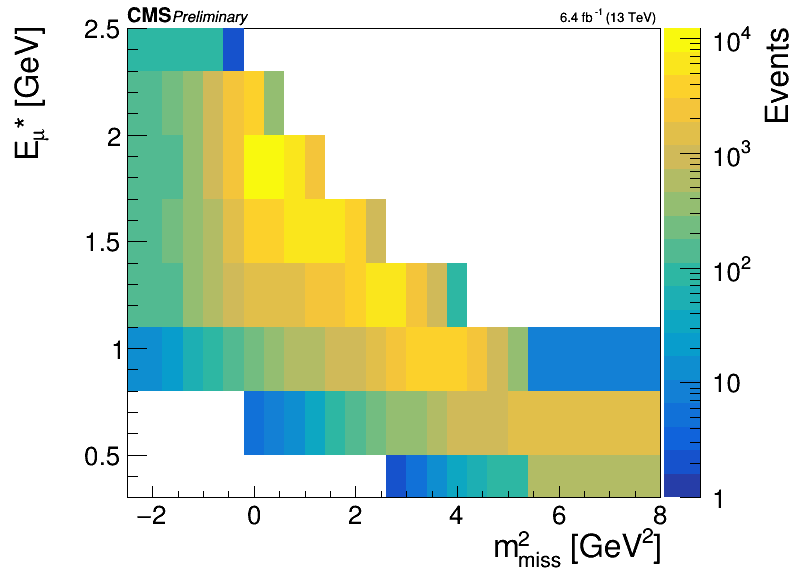

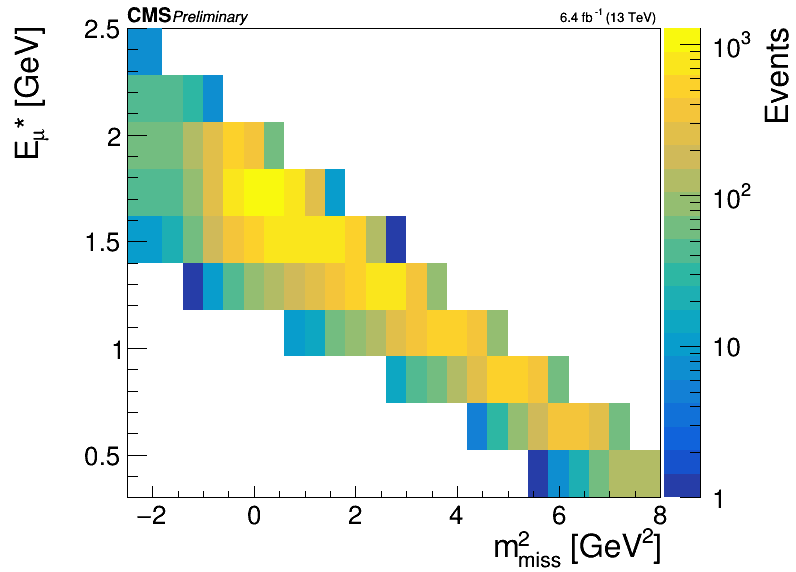

In [27]:
c2D = []
nonEmptyIdxs = []
unrollingCutOff = 3
for i_q2 in range(len(binning['q2'])-1):
    c2D.append(None)
    nonEmptyIdxs.append([])
    name2D = 'h2D_q2bin'+str(i_q2)
    hSum = None
    nDroppedBins = 0
    nExpectedDroppedEvents = 0
    for key, hN in histo[name2D].iteritems():
        if '__' in key:
            continue
        if hSum is None:
            hSum = hN.Clone('hSum_'+str(i_q2))
        else:
            scale = SM_RDst if 'tau' in n else 1.
            hSum.Add(hN, scale)
    hSum.GetXaxis().SetTitle('m^{2}_{miss} [GeV^{2}]')
    hSum.GetYaxis().SetTitle('E_{#mu}* [GeV]')
    hSum.GetZaxis().SetTitle('Events')
    for ix in range(1, hSum.GetNbinsX()+1):
        for iy in range(1, hSum.GetNbinsY()+1):
            if hSum.GetBinContent(ix, iy) > unrollingCutOff:
                nonEmptyIdxs[i_q2].append([ix, iy])
            else:
                nDroppedBins += 1
                nExpectedDroppedEvents += hSum.GetBinContent(ix, iy)
    c2D[i_q2] = drawOnCMSCanvas(CMS_lumi, [hSum], ['colz'], tag=str(i_q2), mR=0.17)
    c2D[i_q2].SaveAs(outdir+'/fig/TotMC_M2Miss_vs_EstMu_q2bin{}.png'.format(i_q2))
    c2D[i_q2].SetLogz()
    print 'Dropped bins:', nDroppedBins
    print 'Expected dropped candidates:', nExpectedDroppedEvents
print 'Considered bins:', [len(l) for l in nonEmptyIdxs]

In [28]:
for i_q2 in range(len(binning['q2'])-1):
    name2D = 'h2D_q2bin'+str(i_q2)
    nameU = 'Unrolled_q2bin'+str(i_q2)
    histo[nameU] = {}
    validBins = nonEmptyIdxs[i_q2]
    for n, h in histo[name2D].iteritems():
        hUnrolled = rt.TH1D(h.GetName(), h.GetTitle(), len(validBins), 0.5, len(validBins)+0.5)
        for i, (ix, iy) in enumerate(validBins):
            hUnrolled.SetBinContent(i+1, h.GetBinContent(ix, iy))
            hUnrolled.SetBinError(i+1, h.GetBinError(ix, iy))
        histo[nameU][n] = hUnrolled

### Single track side

In [29]:
sideSelecton = {}
sideVar = {}

def selfun__TkPlus(ds):
    sel = np.logical_and(ds['N_goodAddTks'] == 1, ds['tkCharge_0'] > 0)
    return sel
#     return np.logical_and(np.abs(ds['tkMassHad_0'] - 2.43) < 0.3, sel)
sideSelecton['AddTk_p_mHad'] = selfun__TkPlus
sideVar['AddTk_p_mHad'] = 'massHadTks'
# sideVar['AddTk_p_mHad'] = 'massHadTks_DstMassConstraint'
binning['AddTk_p_mHad'] = [35, 2.13, 2.83]

def selfun__TkMinus(ds):
    sel = np.logical_and(ds['N_goodAddTks'] == 1, ds['tkCharge_0'] < 0)
    return sel
sideSelecton['AddTk_m_mHad'] = selfun__TkMinus
sideVar['AddTk_m_mHad'] = 'massHadTks'
binning['AddTk_m_mHad'] = [30, 2.1, 3.3]


def selfun__TkPlusMinus(ds):
    sel = np.logical_and(ds['tkCharge_0']+ds['tkCharge_1'] == 0, ds['N_goodAddTks'] == 2)
    sel = np.logical_and(ds['massVisTks'] < 5.3, sel)
    return sel
sideSelecton['AddTk_pm_mVis'] = selfun__TkPlusMinus
sideVar['AddTk_pm_mVis'] = 'massVisTks'
binning['AddTk_pm_mVis'] = array('d', [2.8] + list(np.arange(3., 5.3, 0.1)) + [5.3] )
# binning['AddTk_pm_mVis'] = array('d', list(np.arange(3., 5.3, 0.1)) + [5.3] )


sideSelecton['AddTk_pm_mHad'] = selfun__TkPlusMinus
sideVar['AddTk_pm_mHad'] = 'massHadTks'
binning['AddTk_pm_mHad'] = [30, 2.3, 3.75]

def selfun__TkMinusMinus(ds):
    sel = np.logical_and(ds['tkCharge_0']+ds['tkCharge_1'] == -2, ds['N_goodAddTks'] == 2)
    sel = np.logical_and(ds['massVisTks'] < 5.3, sel)
    return sel
sideSelecton['AddTk_mm_mHad'] = selfun__TkMinusMinus
sideVar['AddTk_mm_mHad'] = 'massHadTks'
binning['AddTk_mm_mHad'] = [15, 2.25, 3.6]

def selfun__TkPlusPlus(ds):
    sel = np.logical_and(ds['tkCharge_0']+ds['tkCharge_1'] == +2, ds['N_goodAddTks'] == 2)
    sel = np.logical_and(ds['massVisTks'] < 5.3, sel)
    return sel
sideSelecton['AddTk_pp_mHad'] = selfun__TkPlusPlus
sideVar['AddTk_pp_mHad'] = 'massHadTks'
binning['AddTk_pp_mHad'] = [15, 2.25, 3.75]

In [30]:
for k in sideSelecton.keys():
    histo[k] = {}

totalCounting = {}
for n in processOrder:
    ds = dSetTkSide[n]
    if n == 'data': continue
    print '\n----------->', n, '<-------------'
    sMC = MCsample[n]    
    wVar = {}
    weights = {}
    
    print 'Including pileup reweighting'
    weights['pileup'] = puReweighter.weightsPileupMC[ds['N_vtx'].astype(np.int)]
#     weights['pileup'] = getPileupWeights(ds)
    print 'Including trigger corrections'
    weights['trg{}SF'.format(cat.trg)], wVar['trg{}SFUp'.format(cat.trg)], wVar['trg{}SFDown'.format(cat.trg)] = computeTrgSF(ds)
    print 'Including muon ID corrections'
    weights['muonIdSF'], wVar['muonIdSFUp'], wVar['muonIdSFDown'] = computeMuonIDSF(ds)
    print 'Including muon pT corrections'
    weights['MuPt'], auxVarDic = computePtWeights(ds, 'mu_pt', 'MuPt', cal_pT_mu)
    wVar.update(auxVarDic)
    
    if n in SamplesB0:
        print 'Including B0 pT corrections'
        weights['B0pT'], auxVarDic = computePtWeights(ds, 'MC_B_pt', 'B0pT', cal_pT_B0)
        wVar.update(auxVarDic)
    if n in SamplesBp:
        print 'Including B +/- pT corrections'
        weights['BpPt'], wVar['BpPtUp'], wVar['BpPtDown'] = computePtWeights(ds, 'MC_B_pt', None, cal_pT_Bp)
    if n in ['mu', 'tau'] and schemeFF != 'NoFF':
        print 'Including FF corrections (Hammer)'
        weights['B2DstFF'] = ds['wh_'+schemeFF+'Central']*sMC.effCand['rate_den']/sMC.effCand['rate_'+schemeFF+'Central']
        for nPar in FreeParFF:
            for var in ['Up', 'Down']:
                tag = schemeFF + nPar + var
                wVar['B2Dst'+tag] = ds['wh_'+tag]/ds['wh_'+schemeFF+'Central']
                wVar['B2Dst'+tag] *= sMC.effCand['rate_'+schemeFF+'Central']/sMC.effCand['rate_' + tag]
    #Dstst resonance mix
    if n == 'DstPip' or n == 'TauDstPip':
        _, wVar['fDststWideUp'], wVar['fDststWideDown'] = computeBrVarWeights(ds, {'MC_munuSisterPdgId': -20423}, 0.6/2.7, keepNorm=True) #Gamma 14 pdg 2020
        widthMods = [
            [10423, 2.422, 0.020],
            [20423, 2.445, 0.250],
            [425, 2.461, 0.043],
        ]
#         _, wVar['DstPipWidthUp'], wVar['DstPipWidthDown'] = computeWidthVarWeights(ds, selItems=widthMods, relScale=0.15)
        _, wVar['D2420_10WidthUp'], wVar['D2420_10WidthDown'] = computeWidthVarWeights(ds, selItems=[[10423, 2.422, 0.020]], relScale=0.15)
        _, wVar['D2430_10WidthUp'], wVar['D2430_10WidthDown'] = computeWidthVarWeights(ds, selItems=[[20423, 2.445, 0.250]], relScale=0.1)
        _, wVar['D2460_1StWidthUp'], wVar['D2460_1StWidthDown'] = computeWidthVarWeights(ds, selItems=[[425, 2.461, 0.043]], relScale=0.15)
    if n == 'DstPipPim' or n == 'DstPi0Pi0':
        widthMods = [[100413, 2.640, 0.200]]
        _, wVar['DstPiPiWidthUp'], wVar['DstPiPiWidthDown'] = computeWidthVarWeights(ds, selItems=widthMods, relScale=0.1)
    #Hc mix variations
    if n == 'DstmD0':
        _, wVar['BrB02DstD0KpUp'], wVar['BrB02DstD0KpDown'] = computeBrVarWeights(ds, {'MC_DstSisterPdgId_heavy': 421, 'MC_DstSisterPdgId_light': 321}, 0.21/2.47) #Gamma 169 pdg 2020
        _, wVar['BrB02DstD0KstpUp'], wVar['BrB02DstD0KstpDown'] = computeBrVarWeights(ds, {'MC_DstSisterPdgId_heavy': 421, 'MC_DstSisterPdgId_light': 323}, 0.5) # Guess
        _, wVar['BrB02DstDst0KpUp'], wVar['BrB02DstDst0KpDown'] = computeBrVarWeights(ds, {'MC_DstSisterPdgId_heavy': 423, 'MC_DstSisterPdgId_light': 321}, 0.09/1.06) #Gamma 170 pdg 2020
        _, wVar['BrB02DstDst0KstpUp'], wVar['BrB02DstDst0KstpDown'] = computeBrVarWeights(ds, {'MC_DstSisterPdgId_heavy': 423, 'MC_DstSisterPdgId_light': 323}, 0.5) # Guess
        _, wVar['BrB02DstDstpK0Up'], wVar['BrB02DstDstpK0Down'] = computeBrVarWeights(ds, {'MC_DstSisterPdgId_heavy': 413, 'MC_DstSisterPdgId_light': 311}, 0.5/5.3) #Gamma 173 pdg 2020
        _, wVar['BrB02DstDstpKst0Up'], wVar['BrB02DstDstpKst0Down'] = computeBrVarWeights(ds, {'MC_DstSisterPdgId_heavy': 413, 'MC_DstSisterPdgId_light': 313}, 0.5) # Guess
    if n == 'DstmDp':
        _, wVar['BrB02DstDpK0Up'], wVar['BrB02DstDpK0Down'] = computeBrVarWeights(ds, {'MC_DstSisterPdgId_heavy': 411, 'MC_DstSisterPdgId_light': 311}, 0.5/3.2) #Gamma 172 pdg 2020
        _, wVar['BrB02DstDpKst0Up'], wVar['BrB02DstDpKst0Down'] = computeBrVarWeights(ds, {'MC_DstSisterPdgId_heavy': 411, 'MC_DstSisterPdgId_light': 313}, 0.5) # Guess
        _, wVar['BrB02DstDstpK0Up'], wVar['BrB02DstDstpK0Down'] = computeBrVarWeights(ds, {'MC_DstSisterPdgId_heavy': 413, 'MC_DstSisterPdgId_light': 311}, 0.2/2.7) #Gamma 173 pdg 2020
        _, wVar['BrB02DstDstpKst0Up'], wVar['BrB02DstDstpKst0Down'] = computeBrVarWeights(ds, {'MC_DstSisterPdgId_heavy': 413, 'MC_DstSisterPdgId_light': 313}, 0.5) # Guess
    if n == 'DstmDsp':
        _, wVar['BrB02DstDsUp'], wVar['BrB02DstDsDown'] = computeBrVarWeights(ds, {'MC_DstSisterPdgId_heavy': 431}, 1.1/8.0) #Gamma 83 pdg 2020
        _, wVar['BrB02DstDsstUp'], wVar['BrB02DstDsstDown'] = computeBrVarWeights(ds, {'MC_DstSisterPdgId_heavy': 433}, .14/1.77) #Gamma 85 pdg 2020
        _, wVar['BrB02DstDs0stUp'], wVar['BrB02DstDs0stDown'] = computeBrVarWeights(ds, {'MC_DstSisterPdgId_heavy': 10431}, .6/1.5) #Gamma 95 pdg 2020
        
    # Correct the amount of random tracks from PV
    weights['tkPVfrac'], wVar['tkPVfracUp'], wVar['tkPVfracDown'] = computeTksPVweights(ds, relScale=0.1)
    
    print 'Computing total weights'
    weightsCentral = np.ones_like(ds['q2'])
    for w in weights.values(): 
        weightsCentral *= w
    wVar[''] = np.ones_like(weightsCentral)
    
    nGenExp = sMC.effMCgen['xsec'][0] * lumi_tot * RDoMC_normRatio
    eff = [1, 0]
    for f, df in [sMC.effMCgen['effGEN'], 
                  decayBR[n], 
                  sMC.effCand['effCAND'], 
                  sMC.getSkimEff(cat.name+'_trkCtrl_corr'),
                 ]:
        eff[0] *= f
        eff[1] += np.square(df/f)
    eff[1] = eff[0] * np.sqrt(eff[1])
    nTotExp = nGenExp*eff[0]
    
    sel = {}
    scale = {}
    
    latexTableString = {}
    for k, selFun in sideSelecton.iteritems():
        sel[k] = selFun(ds)
        nTotSel = float(np.sum(sel[k]))
        print 'N tot selected {}: {:.0f}'.format(k, nTotSel)
        nExp = nTotExp * nTotSel / sel[k].shape[0]
        print 'N tot expected {} (before weights): {:.0f}'.format(k, nExp)
        nAux = nTotExp * np.sum(weightsCentral[sel[k]]) / sel[k].shape[0]
        print 'N tot expected {} (after weights): {:.0f}'.format(k, nAux)
        latexTableString[k] = '{:.0f} ({:.0f})'.format(nAux, nTotSel)
        if not k in totalCounting.keys():
            totalCounting[k] = [0, 0]
        totalCounting[k][0] += nAux
        totalCounting[k][1] += nTotSel
        if nTotSel ==0: 
            nTotSel+=1
        scale[k] = nExp/nTotSel
    s = ' & '.join([latexTableString['AddTk_'+s+'_mHad'] for s in ['p', 'm', 'pp', 'pm', 'mm']])
    print s
    eventCountingStr[n] += ' & ' + s + '\\\\'
    
            
    for name_wVar, v_wVar in wVar.iteritems():
        h_name = n
        if not name_wVar == '':
            h_name += '__' + name_wVar
        w = weightsCentral*v_wVar
        
        for k in sideVar.keys():
            histo[k][h_name] = create_TH1D(
                                           ds[sideVar[k]][sel[k]], 
                                           name=h_name, title=h_name, 
                                           binning=binning[k],
                                           opt='underflow',
                                           weights=w[sel[k]], scale_histo=scale[k]
                                          )
            
s = ' & '.join(['{:.0f} ({:.0f})'.format(*totalCounting['AddTk_'+s+'_mHad']) for s in ['p', 'm', 'pp', 'pm', 'mm']]) + ' \\\\'
eventCountingStr['tot'] += ' & ' + s


-----------> tau <-------------
Including pileup reweighting
Including trigger corrections
Including muon ID corrections
Including muon pT corrections
Including B0 pT corrections
Including FF corrections (Hammer)
Computing total weights
N tot selected AddTk_pm_mHad: 208
N tot expected AddTk_pm_mHad (before weights): 94
N tot expected AddTk_pm_mHad (after weights): 270
N tot selected AddTk_m_mHad: 2021
N tot expected AddTk_m_mHad (before weights): 917
N tot expected AddTk_m_mHad (after weights): 1323
N tot selected AddTk_p_mHad: 2312
N tot expected AddTk_p_mHad (before weights): 1049
N tot expected AddTk_p_mHad (after weights): 1606
N tot selected AddTk_pp_mHad: 82
N tot expected AddTk_pp_mHad (before weights): 37
N tot expected AddTk_pp_mHad (after weights): 84
N tot selected AddTk_mm_mHad: 70
N tot expected AddTk_mm_mHad (before weights): 32
N tot expected AddTk_mm_mHad (after weights): 83
N tot selected AddTk_pm_mVis: 208
N tot expected AddTk_pm_mVis (before weights): 94
N tot expec

Including muon ID corrections
Including muon pT corrections
Including B +/- pT corrections
10423 2.422 0.02
20423 2.445 0.25
425 2.461 0.043
Computing total weights
N tot selected AddTk_pm_mHad: 561
N tot expected AddTk_pm_mHad (before weights): 8
N tot expected AddTk_pm_mHad (after weights): 14
N tot selected AddTk_m_mHad: 291
N tot expected AddTk_m_mHad (before weights): 4
N tot expected AddTk_m_mHad (after weights): 7
N tot selected AddTk_p_mHad: 16674
N tot expected AddTk_p_mHad (before weights): 247
N tot expected AddTk_p_mHad (after weights): 318
N tot selected AddTk_pp_mHad: 429
N tot expected AddTk_pp_mHad (before weights): 6
N tot expected AddTk_pp_mHad (after weights): 11
N tot selected AddTk_mm_mHad: 15
N tot expected AddTk_mm_mHad (before weights): 0
N tot expected AddTk_mm_mHad (after weights): 0
N tot selected AddTk_pm_mVis: 561
N tot expected AddTk_pm_mVis (before weights): 8
N tot expected AddTk_pm_mVis (after weights): 14
318 (16674) & 7 (291) & 11 (429) & 14 (561) & 0

## Create (pseudo-)data histogram

In [31]:
if use_real_data:
    ds = dSet['data']
    print 'N observed data signal region: {:.1f}k'.format(1e-3*ds['q2'].shape[0])
    if useMVA:
        print 'Evaluating MVA'
        sMVA = computeVarMVA(ds)
        histo['MVA']['data'] = create_TH1D(sMVA, name='data_obs', binning=binning['MVA'], opt='underflow,overflow')
                
    for i_q2 in range(len(binning['q2'])-1):
        q2_l = binning['q2'][i_q2]
        q2_h = binning['q2'][i_q2 + 1]
        sel_q2 = np.logical_and(ds['q2'] > q2_l, ds['q2'] < q2_h)
        for var in ['M2_miss', 'Est_mu']:
            cat_name = var+'_q2bin'+str(i_q2)     
            histo[cat_name]['data'] = create_TH1D(
                                                  ds[var][sel_q2], 
                                                  name='data_obs', title='Data Obs',
                                                  binning=binning[var][i_q2],
                                                  opt='underflow,overflow'
                                                 )
            if not var == 'M2_miss': 
                    continue
            auxS = np.column_stack((ds['M2_miss'][sel_q2], ds['Est_mu'][sel_q2]))
            cat2D = 'h2D_q2bin'+str(i_q2)
            histo[cat2D]['data'] = create_TH2D(auxS, name='data_obs', title='Data Obs', 
                                               binning=binning_2D[i_q2])
            catU = 'Unrolled_q2bin'+str(i_q2)
            validBins = nonEmptyIdxs[i_q2]
            hUnrolled = rt.TH1D('data_obs', 'Data Obs', len(validBins), 0.5, len(validBins)+0.5)
            for i, (ix, iy) in enumerate(validBins):
                hUnrolled.SetBinContent(i+1, histo[cat2D]['data'].GetBinContent(ix, iy))
                hUnrolled.SetBinError(i+1, histo[cat2D]['data'].GetBinError(ix, iy))
            histo[catU]['data'] = hUnrolled
            
    for var in ['B_pt', 'B_eta']:
        histo[var]['data'] = create_TH1D(ds[var], name='data_obs', binning=binning[var], opt='underflow,overflow')
        
    ds = dSetTkSide['data']
    for k in sideVar.keys():
        histo[k]['data'] = create_TH1D(
                                       ds[sideVar[k]][sideSelecton[k](ds)], 
                                       name='data_obs', title='Data Obs', 
                                       binning=binning[k],
                                       opt='underflow',
                                      )
    print 'N observed data control regions: ' + ' & '.join(['{:.0f}'.format(histo['AddTk_'+s+'_mHad']['data'].Integral()) for s in ['p', 'm', 'pp', 'pm', 'mm']]) + ' \\\\'
        
else:
    if useMVA:
        h = create_TH1D(np.array([0, 0]), name='data_obs', title='Data Obs', binning=binning['MVA'])
        h.Reset()
        for n, hMC in histo['MVA'].iteritems():
                if not '__' in n and not n == 'data':
                    scale = SM_RDst if 'tau' in n else 1.
                    h.Add(hMC, scale)
        h.Sumw2(0)
        for i in range(1, h.GetNbinsX()+1):
            h.SetBinContent(i, np.around(h.GetBinContent(i)))
        h.Sumw2()
        histo['MVA']['data'] = h
    for i_q2 in range(len(binning['q2'])-1):
        for var in ['M2_miss', 'Est_mu', 'Unrolled', 'h2D']:
            cat_name = var+'_q2bin'+str(i_q2)
            
            h = histo[cat_name].values()[0].Clone('data_obs')
            h.SetTitle('Data Obs')
            h.Reset()
            for n, hMC in histo[cat_name].iteritems():
                if not '__' in n and not n == 'data':
                    scale = SM_RDst if 'tau' in n else 1.
                    h.Add(hMC, scale)
            h.Sumw2(0)
            
            for ix in range(1, h.GetNbinsX()+1):
                if h.GetNbinsY() > 1:
                    for iy in range(1, h.GetNbinsY()+1):
                        h.SetBinContent(ix, iy, np.around(h.GetBinContent(ix, iy)))
                else:
                    h.SetBinContent(ix, np.around(h.GetBinContent(ix)))
            h.Sumw2()
            histo[cat_name]['data'] = h
            
    for var in ['B_pt', 'B_eta']:
        h = create_TH1D(np.array([0, 0]), name='data_obs', title='Data Obs', binning=binning[var])
        h.Reset()
        for n, hMC in histo[var].iteritems():
                if not '__' in n and not n == 'data':
                    scale = SM_RDst if 'tau' in n else 1.
                    h.Add(hMC, scale)
        h.Sumw2(0)
        for i in range(1, h.GetNbinsX()+1):
            h.SetBinContent(i, np.around(h.GetBinContent(i)))
        h.Sumw2()
        histo[var]['data'] = h
            
    for k in sideVar.keys():
        h = create_TH1D(np.array([0, 0]), name='data_obs', title='Data Obs', 
                        binning=binning[k])
        h.Reset()
        for n, hMC in histo[k].iteritems():
            if not '__' in n and not n == 'data':
                scale = SM_RDst if 'tau' in n else 1.
                h.Add(hMC, scale)
        h.Sumw2(0)
        for i in range(1, h.GetNbinsX()+1):
            h.SetBinContent(i, np.around(h.GetBinContent(i)))
        h.Sumw2()
        histo[k]['data'] = h

N observed data signal region: 350.3k
N observed data control regions: 39010 & 19984 & 1988 & 7300 & 1083 \\


## Dump root file

In [32]:
if not os.path.isdir(histo_file_dir):
    os.makedirs(histo_file_dir)

for cat_name, h_dic in histo.iteritems():
    tf = rt.TFile(histo_file_dir+'{}_{}.root'.format(card_name, cat_name), 'recreate')
    for v in h_dic.values():
        v.Write()
    tf.Close()
    
del dSet, dSetTkSide

# Pre-fit plots

In [33]:
if not 'histo' in vars().keys(): histo = loadHisto4CombineFromRoot(histo_file_dir, card_name)

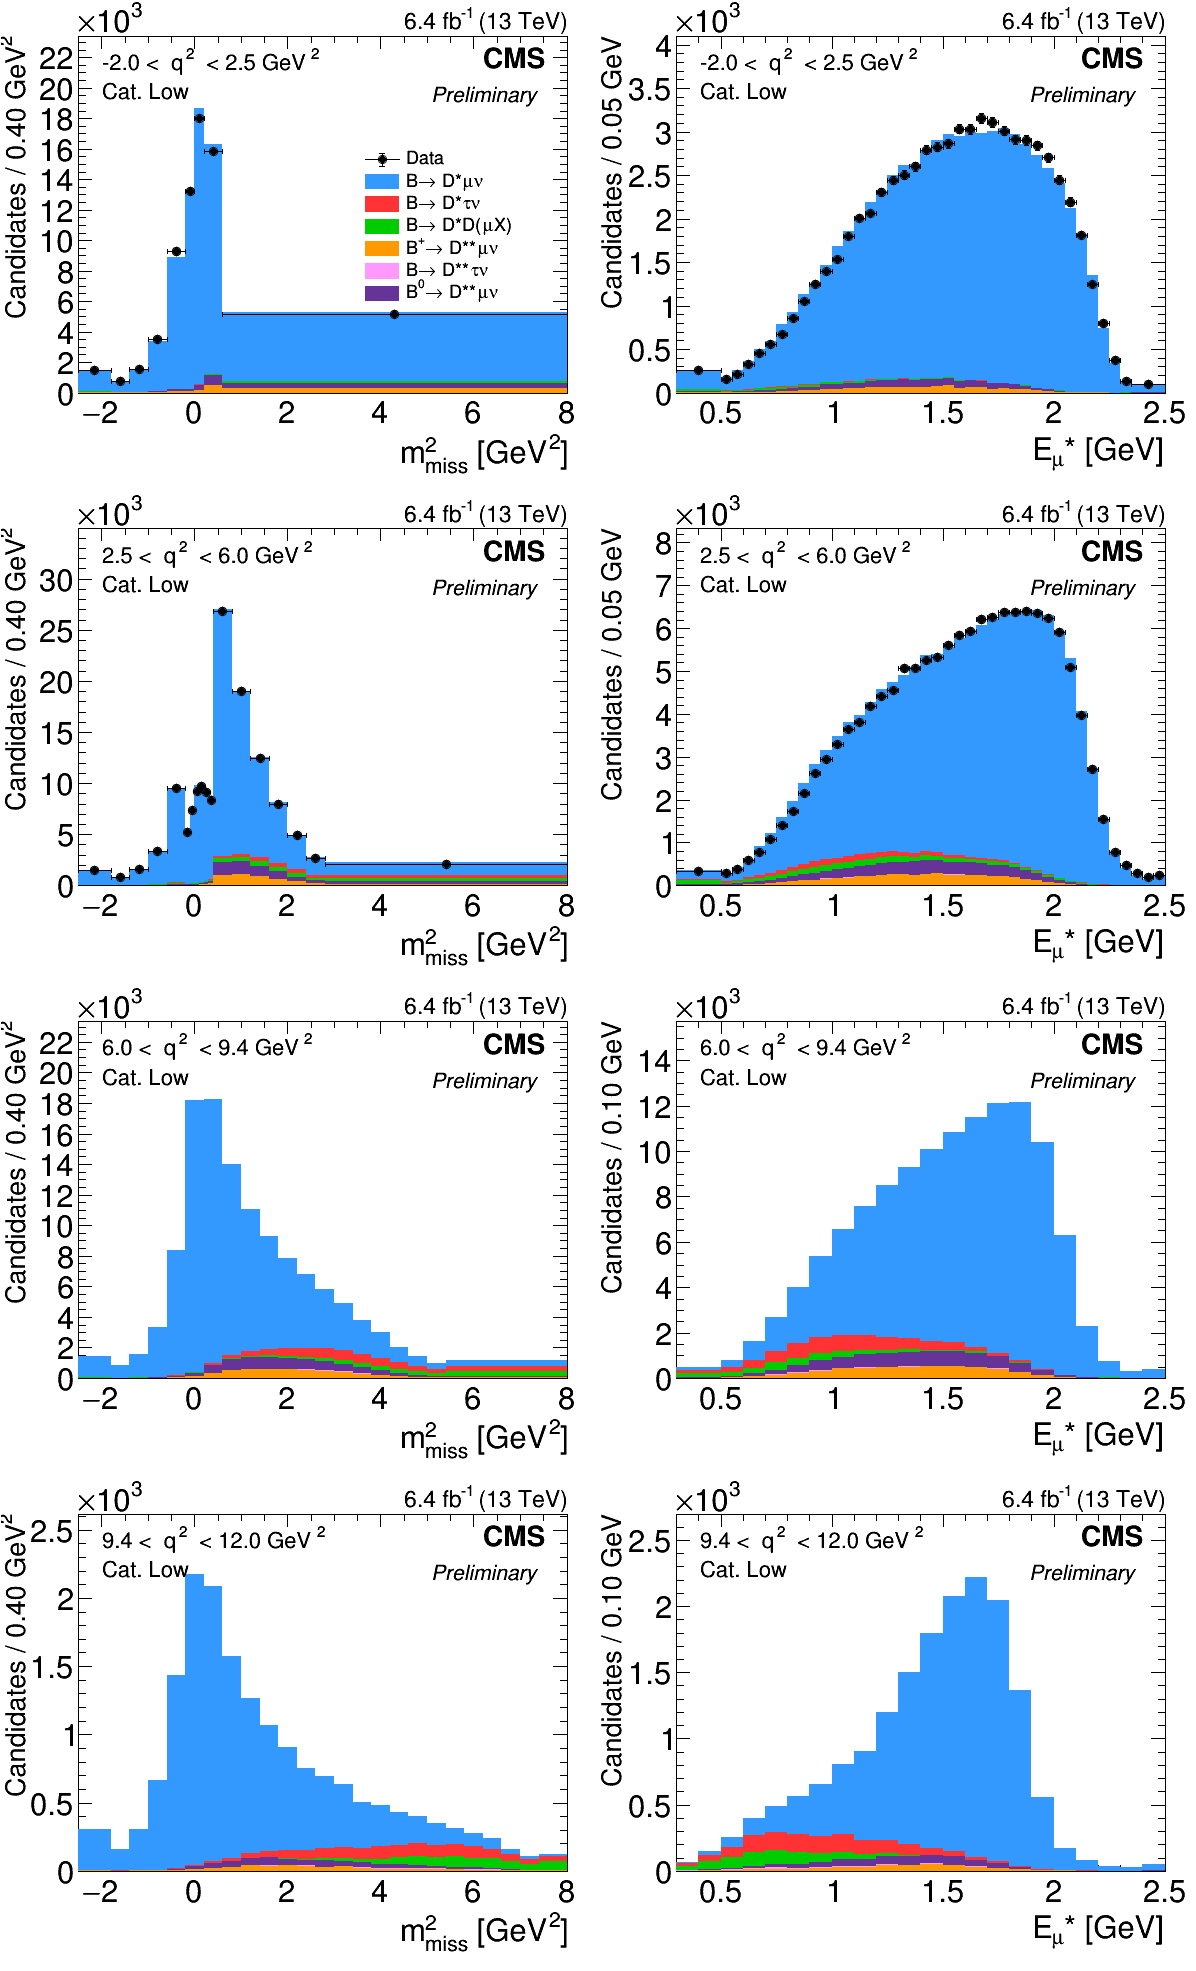

In [34]:
CMS_lumi.integrated_lumi = lumi_tot
scale_dic = {'tau': SM_RDst}

cSigPre = plot_gridVarQ2(CMS_lumi, binning, histo, 
                         scale_dic=scale_dic, min_y=0, logy=False, 
                         categoryText=cat.name.capitalize(),
                         iq2_maskData=[2, 3] if blinded_fit else [])

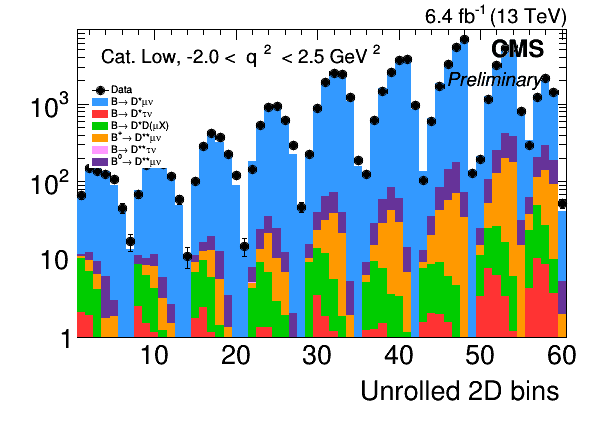

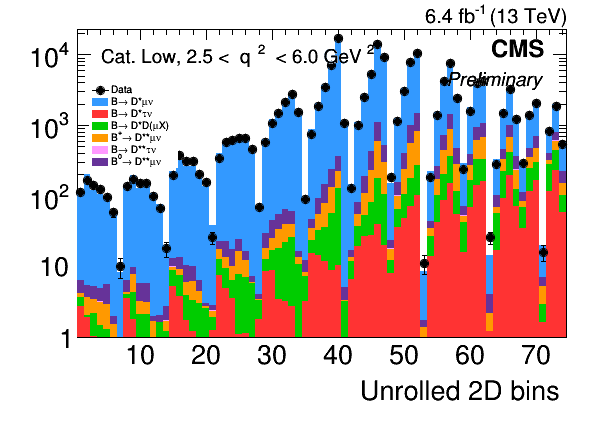

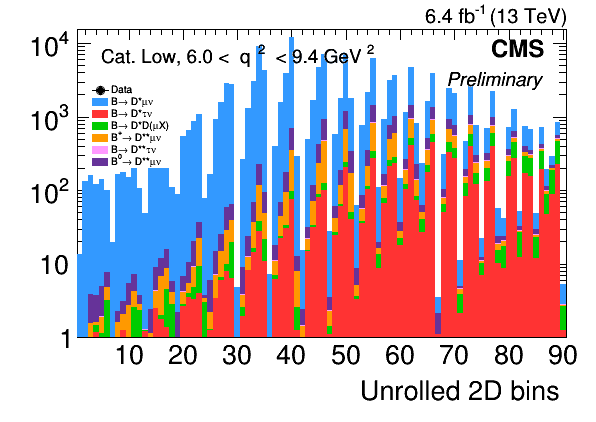

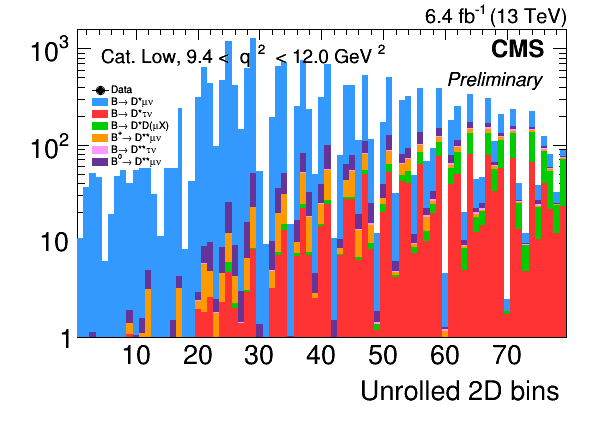

In [35]:
cUnrolledPre = []
for i_q2 in range(len(binning['q2'])-1):
    q2_l = binning['q2'][i_q2]
    q2_h = binning['q2'][i_q2 + 1]
    nameU = 'Unrolled_q2bin'+str(i_q2)
    histo[nameU]['data'].GetXaxis().SetTitle('Unrolled 2D bins')
    histo[nameU]['data'].GetYaxis().SetTitle('Events')
    cUnrolledPre.append(plot_SingleCategory(CMS_lumi, histo[nameU], scale_dic=scale_dic,
                                            addText='Cat. '+category.capitalize()+', {:.1f} <  q^{{2}}  < {:.1f} GeV^{{2}}'.format(q2_l, q2_h), 
                                            logy=True, legBkg=True,
                                            procOrder = ['tau', 'DstD', 'Dstst', 'mu'],
                                            min_y=1, 
                                            tag='Unrolled_q2bin'+str(i_q2), 
                                            legLoc=[0.15, 0.6, 0.3, 0.8],
                                            maskData = blinded_fit and (False if i_q2 < 2 else True)
                                      ))

In [36]:
if useMVA:
    histo['MVA']['data'].GetXaxis().SetTitle('MVA score')
    histo['MVA']['data'].GetYaxis().SetTitle('Events')
    cMVAPre = plot_SingleCategory(CMS_lumi, histo['MVA'], scale_dic=scale_dic,
                                  addText='', logy=True, legBkg=True,
                                  procOrder = ['tau', 'DstD', 'Dstst', 'mu'],
                                  min_y=1, tag='MVA', legLoc=[0.25, 0.4, 0.5, 0.7])

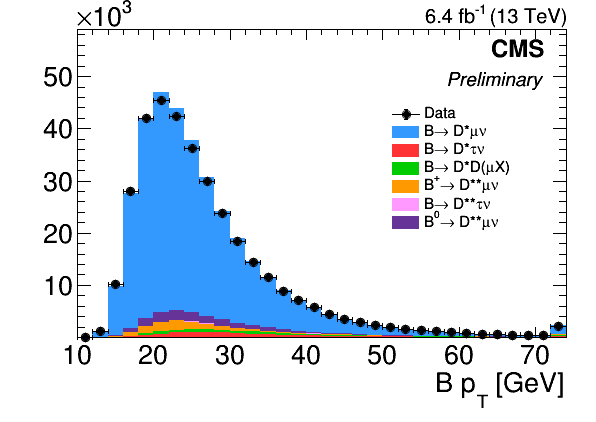

In [37]:
histo['B_pt']['data'].GetXaxis().SetTitle('B p_{T} [GeV]')
histo['B_pt']['data'].GetYaxis().SetTitle('Events')
cB_pt_pre = plot_SingleCategory(CMS_lumi, histo['B_pt'], scale_dic=scale_dic, 
                                addText='', logy=False, legBkg=True,
                                procOrder = ['tau', 'DstD', 'Dstst', 'mu'],
                                min_y=1, tag='B_pt', legLoc=[0.65, 0.45, 0.9, 0.75])

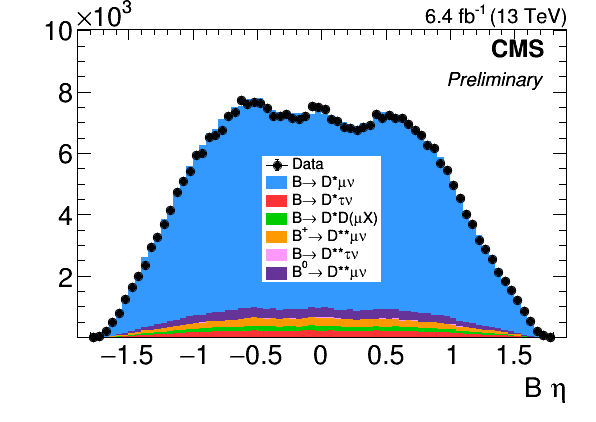

In [38]:
histo['B_eta']['data'].GetXaxis().SetTitle('B #eta')
histo['B_eta']['data'].GetYaxis().SetTitle('Events')
cB_eta_pre = plot_SingleCategory(CMS_lumi, histo['B_eta'], scale_dic=scale_dic,
                                 addText='', logy=False, legBkg=True,
                                 procOrder = ['tau', 'DstD', 'Dstst', 'mu'],
                                 min_y=1, tag='B_eta', legLoc=[0.44, 0.33, 0.64, 0.63])

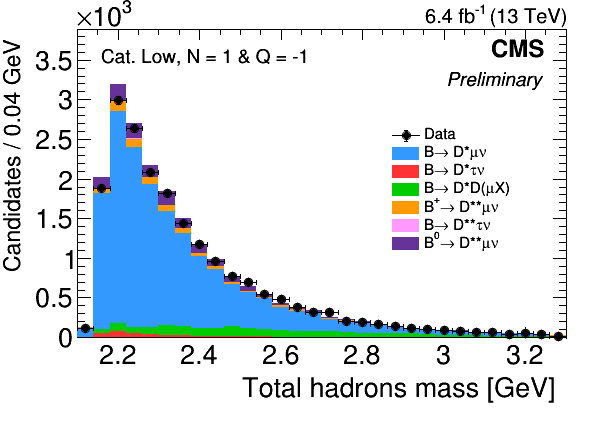

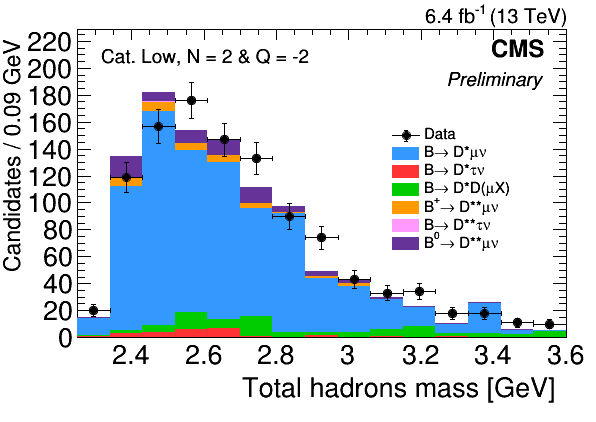

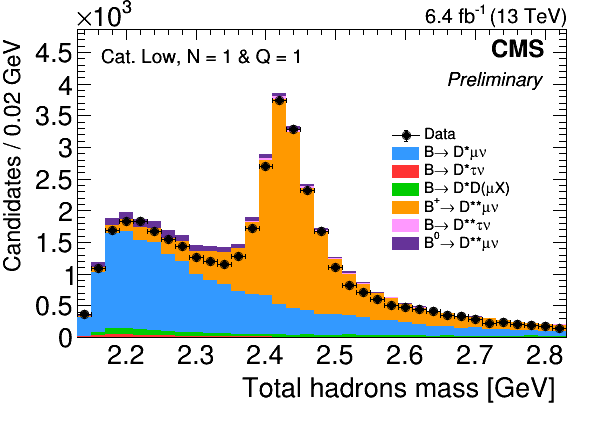

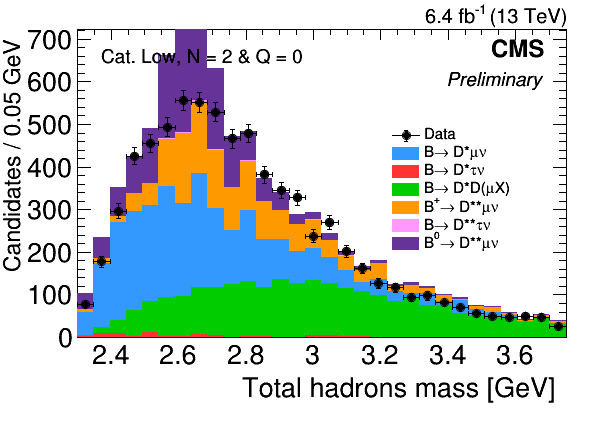

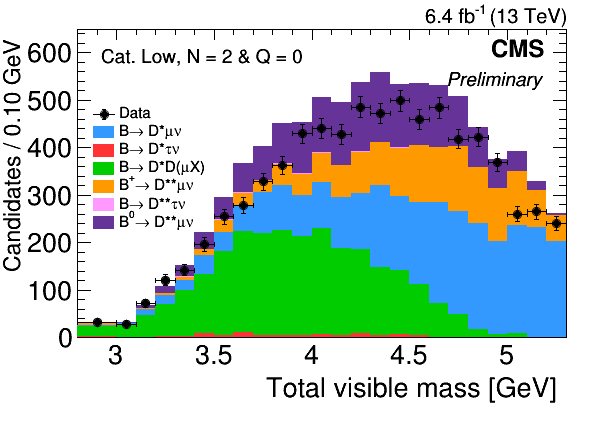

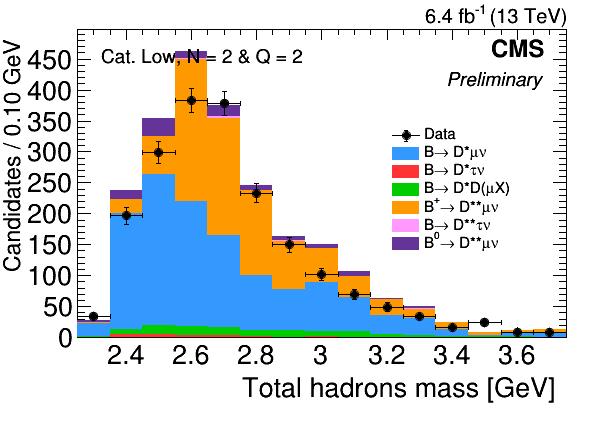

In [39]:
cSidePre = {}
for k in np.sort([k for k in histo.keys() if 'AddTk' in k]):
    legLoc = [0.65, 0.4, 0.9, 0.7]
    if 'Vis' in k:
        legLoc = [0.15, 0.45, 0.35, 0.75]
    cSidePre[k] = plot_SingleCategory(CMS_lumi, histo[k], scale_dic=scale_dic,
                                      xtitle=getControlXtitle(k), 
                                      addText='Cat. '+cat.name.capitalize() + ', ' + getControlSideText(k), 
                                      min_y=0, tag=k, legLoc=legLoc)

# Write the card

In [40]:
if not 'histo' in vars().keys(): histo = loadHisto4CombineFromRoot(histo_file_dir, card_name)
fitRegionsOnly = False

In [41]:
sig_processes = ['tau', 'mu']
bkg_processes = ['DstmD0', 'DstmDp', 'DstmDsp', 
                 'BpDstmHc', 'BmDstmHc', 'antiB0DstmHc',
                 'DstPip', 'DstPipPi0', 
                 'DstPi0', 'DstPipPim', 'DstPi0Pi0',
                 'TauDstPip', 'TauDstPi0'
                ]
processes = sig_processes + bkg_processes
nProc = len(processes)
categories = []
for c in np.sort(histo.keys()):
    if c.startswith('h2'): continue
    
    if fitRegionsOnly:
        if c.startswith('B_pt'): continue
        if c.startswith('B_eta'): continue
        if c.startswith('Est_mu'): continue
        if c.startswith('M2_miss'): continue
        if c == 'AddTk_pm_mHad': continue
        if blinded_fit and (c.endswith('_q2bin2') or c.endswith('_q2bin3')): continue
    categories.append(c)

nCat = len(categories)

In [42]:
# number of different categories
card = 'imax *\n'
# number of background (not scaled by the auto rateParam r) processes
card += 'jmax {}\n'.format(len(processes)-1)
# number of nuissance parameters
card += 'kmax *\n'
card += 60*'-'+'\n'

In [43]:
# shape file location
for k in categories:
    fname = histo_file_dir+'{}_{}.root'.format(card_name, k)
    card += 'shapes * {} {} $PROCESS $PROCESS__$SYSTEMATIC\n'.format(k, fname)
card += 60*'-'+'\n'

### Number of events

In [44]:
# number of events observed
card += 'bin ' + ' '.join(categories) + '\n'
obs = map(lambda k: '{:.0f}'.format(histo[k]['data'].Integral()), categories)
obs = ' '.join(obs)
card += 'observation ' + obs + '\n'
card += 60*'-'+'\n'

In [45]:
# MC expected events
aux_bin = ''
aux_proc_name = ''
aux_proc_id = ''
aux_proc_rate = ''
for c, p in itertools.product(categories, processes):
    aux_bin += ' '+c
    aux_proc_name += ' '+p
    aux_proc_id += ' '+str(np.argmax(np.array(processes) == p))
    aux_proc_rate += ' {:.2f}'.format(histo[c][p].Integral())
    
card += 'bin' + aux_bin + '\n'
card += 'process' + aux_proc_name + '\n'
# Zero or negative for sig and positive for bkg
card += 'process' + aux_proc_id + '\n'
# Expected rate
card += 'rate' + aux_proc_rate + '\n'
card += 60*'-'+'\n'

## Systematic uncertainties

### Scale systematics

In [46]:
#pp -> bb cros-section * luminosity
card += 'xsecpp2bbXlumi'+cat.trg+' lnN' + ' 1.3'*nProc*nCat + '\n'

In [47]:
# Branching ratio uncertainty
decayBR = pickle.load(open('../data/forcedDecayChannelsFactors.pickle', 'rb'))

for n in processes:
    if n in ['tau', 'DstPip', 'DstPi0', 'DstPipPim', 'DstPipPi0', 'DstPi0Pi0']: continue
#     if n in ['tau', 'DstPip', 'DstPi0', 'DstPipPim', 'DstPipPi0', 'DstPi0Pi0', 'BmDstmHc']: continue
    val = ' {:.2f}'.format(1+decayBR[n][1]/decayBR[n][0])
    aux = ''
    for nn in processes:
        if nn == n or (n=='mu' and nn=='tau'): 
            aux += val
        else: 
            aux += ' -'
    card += n + 'Br lnN' + aux*nCat + '\n'

In [48]:
# Branching ratio uncertainty with isospin symmetry constraint
val = ' {:.2f}'.format(1+decayBR['DstPip'][1]/decayBR['DstPip'][0]) #DstPi0 has no info
aux = ''
for n in processes:
    if n in ['DstPip', 'DstPi0']: aux += val
    else: aux += ' -'
card += 'DstPiBr lnN' + aux*nCat + '\n'

val = ' {:.2f}'.format(1+decayBR['DstPipPim'][1]/decayBR['DstPipPim'][0]) #DstPipPim is the only one meaasured
aux = ''
for n in processes:
    if n in ['DstPipPim', 'DstPipPi0', 'DstPi0Pi0']: aux += val
    else: aux += ' -'
card += 'DstPiPiBr lnN' + aux*nCat + '\n'

In [49]:
card += 60*'-'+'\n'

### Shape Systematics

In [50]:
# card += 'trg{}SF shape'.format(cat.trg) + ' 1.'*nProc*nCat + '\n'
# card += 'muonIdSF shape' + ' 1.'*nProc*nCat + '\n'

In [51]:
aux = ''
for c in categories:
    if c.startswith('AddTk_'):
        aux += ' 1.'*nProc
    else: aux += ' -'*nProc
card += 'tkPVfrac shape' + aux + '\n'

In [52]:
# Mu pT spectrum
aux = ''
for p in processes:
    aux += ' 1.'

names = []
for k in histo.values()[0].keys():
    if k.startswith('mu__MuPt') and k.endswith('Up'):
        names.append(k[4:-2])
for n in sorted(names):
    card += n + ' shape' + aux*nCat + '\n'

In [53]:
# B0 pT spectrum
aux = ''
for p in processes:
    if p in SamplesB0:
        aux += ' 1.'
    else:
        aux += ' -'

names = []
for k in histo.values()[0].keys():
    if k.startswith(SamplesB0[0]+'__B0pT') and k.endswith('Up'):
        names.append(k[4:-2])
for n in sorted(names):
    card += n + ' shape' + aux*nCat + '\n'

In [54]:
# B +/- pT spectrum
aux = ''
for p in processes:
    if p in SamplesBp:
        aux += ' 1.'
    else:
        aux += ' -'

card += 'BpPt shape' + aux*nCat + '\n'

In [55]:
# Form Factors from Hammer
for n_pFF in FreeParFF:
    aux = ''
    for p in processes:
        if p in ['tau', 'mu']:
            aux += ' 1.'
        else:
            aux += ' -'
    card += 'B2Dst'+schemeFF+'{} shape'.format(n_pFF) + aux*nCat + '\n'

In [56]:
# Dstst mix composition
aux = ''
for p in processes:
    if p == 'DstPip' or p == 'TauDstPip': 
        aux += ' 1.'
    else: 
        aux += ' -'
card += 'fDststWide shape' + aux*nCat + '\n'
# card += 'DstPipWidth shape' + aux*nCat + '\n'
card += 'D2420_10Width shape' + aux*nCat + '\n'
card += 'D2430_10Width shape' + aux*nCat + '\n'
card += 'D2460_1StWidth shape' + aux*nCat + '\n'

In [57]:
# Dstst->DstPiPi width
aux = ''
for p in processes:
    if p == 'DstPipPim' or p == 'DstPi0Pi0': 
        aux += ' 1.'
    else: aux += ' -'
card += 'DstPiPiWidth shape' + aux*nCat + '\n'

In [58]:
# Hc mix composition
aux = ''
for p in processes:
    if p == 'DstmD0': aux += ' 1.'
    else: aux += ' -'
card += 'BrB02DstD0Kp shape' + aux*nCat + '\n'
card += 'BrB02DstD0Kstp shape' + aux*nCat + '\n'
card += 'BrB02DstDst0Kp shape' + aux*nCat + '\n'
card += 'BrB02DstDst0Kstp shape' + aux*nCat + '\n'

aux = ''
for p in processes:
    if p == 'DstmDp': aux += ' 1.'
    else: aux += ' -'
card += 'BrB02DstDpK0 shape' + aux*nCat + '\n'
card += 'BrB02DstDpKst0 shape' + aux*nCat + '\n'

aux = ''
for p in processes:
    if p == 'DstmDp' or p == 'DstmD0': aux += ' 1.'
    else: aux += ' -'
card += 'BrB02DstDstpK0 shape' + aux*nCat + '\n'
card += 'BrB02DstDstpKst0 shape' + aux*nCat + '\n'

aux = ''
for p in processes:
    if p == 'DstmDsp': aux += ' 1.'
    else: aux += ' -'
card += 'BrB02DstDs shape' + aux*nCat + '\n'
card += 'BrB02DstDsst shape' + aux*nCat + '\n'
card += 'BrB02DstDs0st shape' + aux*nCat + '\n'

In [59]:
card += 60*'-'+'\n'

### MC statistic systematics

In [60]:
if useMCstats:
    card += 'AddTk_p_mHad autoMCStats 2 1 1\n'
    card += 'AddTk_m_mHad autoMCStats 2 1 1\n'
    # card += 'AddTk_pm_mHad autoMCStats 2 1 1\n'
    card += 'AddTk_pm_mVis autoMCStats 2 1 1\n'
    card += 'AddTk_pp_mHad autoMCStats 2 1 1\n'
    card += 'AddTk_mm_mHad autoMCStats 2 1 1\n'

    if useMVA:
        card += 'MVA autoMCStats 2 1 1\n'
    else:
    #     card += 'Est_mu* autoMCStats 0 1 1\n'
    #     card += 'M2_miss* autoMCStats 0 1 1\n'

        card += 'Unrolled_q2bin0 autoMCStats 0 1 1\n'
        card += 'Unrolled_q2bin1 autoMCStats 0 1 1\n'
        if not blinded_fit:
            card += 'Unrolled_q2bin2 autoMCStats 0 1 1\n'
            card += 'Unrolled_q2bin3 autoMCStats 0 1 1\n'

    card += 60*'-'+'\n'

### Defining groups of systematics

In [61]:
# autoMCStats group = defined by default when using autoMCStats
if len(FreeParFF):
    aux_FF = ' '.join(['B2Dst'+schemeFF+n for n in FreeParFF])
    card += 'B2DstFF group = ' + aux_FF + '\n'

cardParts = card.split(60*'-'+'\n')

scaleNuis = []
for ln in cardParts[4].split('\n'):
    scaleNuis.append(ln.split(' ')[0])
    
shapeNuis = []
for ln in cardParts[5].split('\n'):
    if 'autoMCStats' in ln:
        continue
    shapeNuis.append(ln.split(' ')[0])

card += 'allSys group = ' + ' '.join(scaleNuis+shapeNuis) + '\n'

## Create output

In [62]:
print card

imax *
jmax 14
kmax *
------------------------------------------------------------
shapes * AddTk_m_mHad /storage/user/ocerri/BPhysics/data/_root/histos4combine/v16low_CLN_blinded_AddTk_m_mHad.root $PROCESS $PROCESS__$SYSTEMATIC
shapes * AddTk_mm_mHad /storage/user/ocerri/BPhysics/data/_root/histos4combine/v16low_CLN_blinded_AddTk_mm_mHad.root $PROCESS $PROCESS__$SYSTEMATIC
shapes * AddTk_p_mHad /storage/user/ocerri/BPhysics/data/_root/histos4combine/v16low_CLN_blinded_AddTk_p_mHad.root $PROCESS $PROCESS__$SYSTEMATIC
shapes * AddTk_pm_mHad /storage/user/ocerri/BPhysics/data/_root/histos4combine/v16low_CLN_blinded_AddTk_pm_mHad.root $PROCESS $PROCESS__$SYSTEMATIC
shapes * AddTk_pm_mVis /storage/user/ocerri/BPhysics/data/_root/histos4combine/v16low_CLN_blinded_AddTk_pm_mVis.root $PROCESS $PROCESS__$SYSTEMATIC
shapes * AddTk_pp_mHad /storage/user/ocerri/BPhysics/data/_root/histos4combine/v16low_CLN_blinded_AddTk_pp_mHad.root $PROCESS $PROCESS__$SYSTEMATIC
shapes * B_eta /storage/user/ocer

In [63]:
if fitRegionsOnly:
    fc = open(card_location.replace('.txt', '_fitRegionsOnly.txt'), 'w')
else:
    fc = open(card_location, 'w')
fc.write(card)
fc.close()

In [64]:
if not os.path.isdir(outdir):
    os.system('mkdir -p ' + outdir + '/fig');

if 'processOrder' in vars().keys():
    with open(outdir + '/eventCounting.txt', 'w') as f:
        for p in processOrder + ['tot']:
            f.write(p + '   ' + eventCountingStr[p] + '\n')

# Run Combine

In [65]:
if not runCombine:
    raise

In [66]:
globalChannelMasking = [
#     'AddTk_p_mHad',
#     'AddTk_m_mHad',
#     'AddTk_pm_mVis',
    'AddTk_pm_mHad',
#     'AddTk_pp_mHad',
#     'AddTk_mm_mHad',
#     'Unrolled_q2bin0',
#     'Unrolled_q2bin1',
#     'Unrolled_q2bin2',
#     'Unrolled_q2bin3', 
    'B_pt',
    'B_eta',
    'Est_mu_q2bin0',
    'Est_mu_q2bin1',
    'Est_mu_q2bin2',
    'Est_mu_q2bin3',
    'M2_miss_q2bin0',
    'M2_miss_q2bin1',
    'M2_miss_q2bin2',
    'M2_miss_q2bin3',
#     'MVA'
]

if blinded_fit:
    globalChannelMasking += ['Unrolled_q2bin2', 'Unrolled_q2bin3']
#     globalChannelMasking += ['M2_miss_q2bin2', 'M2_miss_q2bin3']
    pass

globalChannelMaskingStr = ','.join(['mask_{}=1'.format(c) for c in globalChannelMasking])
print globalChannelMaskingStr

mask_AddTk_pm_mHad=1,mask_B_pt=1,mask_B_eta=1,mask_Est_mu_q2bin0=1,mask_Est_mu_q2bin1=1,mask_Est_mu_q2bin2=1,mask_Est_mu_q2bin3=1,mask_M2_miss_q2bin0=1,mask_M2_miss_q2bin1=1,mask_M2_miss_q2bin2=1,mask_M2_miss_q2bin3=1,mask_Unrolled_q2bin2=1,mask_Unrolled_q2bin3=1


## Create the workspace

In [67]:
aux = card_location
if fitRegionsOnly:
    print 'Creating the FitRegionsOnly workspace'
    aux = card_location.replace('.txt', '_fitRegionsOnly.txt')

cmd = 'text2workspace.py ' + aux 
cmd += ' -o ' + aux.replace('.txt', '.root')
cmd += ' --no-b-only'
cmd += ' --verbose 1'
cmd += ' --channel-masks'
# cmd += ' --no-wrappers'
status, output = commands.getstatusoutput(cmd)
if status: 
    print output
    raise
else:
    text_file = open(aux.replace('.txt', '_text2workspace.out'), "w")
    text_file.write(output)
    text_file.close()

In [68]:
if runScanOnly:
    channelMasking = [
#         'AddTk_p_mHad',
#         'AddTk_m_mHad',
#         'AddTk_pm_mVis',
        'AddTk_pm_mHad',
#         'AddTk_pp_mHad',
#         'AddTk_mm_mHad',
        'Unrolled_q2bin0',
        'Unrolled_q2bin1',
        'Unrolled_q2bin2',
        'Unrolled_q2bin3', 
#         'Est_mu_q2bin0',
#         'Est_mu_q2bin1',
#         'Est_mu_q2bin2',
#         'Est_mu_q2bin3',
        'M2_miss_q2bin0',
        'M2_miss_q2bin1',
        'M2_miss_q2bin2',
        'M2_miss_q2bin3',
#         'MVA',
    ]
    scan_tag='EstMuOnly'
    
    cmd = 'combine'
    cmd += ' -M MultiDimFit'
    cmd += ' --algo grid --points=100'
#     cmd += ' --cminDefaultMinimizerType Minuit2'
#     cmd += ' --cminDefaultMinimizerAlgo Migrad'
#     cmd += ' --cminDefaultMinimizerTolerance=0.2'
#     cmd += ' --setRobustFitStrategy 2 --setRobustFitTolerance 0.001'
    cmd += ' --cminDefaultMinimizerStrategy=2 --robustFit 1'
    cmd += ' --X-rtd MINIMIZER_analytic'
    cmd += ' -d ' + card_location.replace('.txt', '.root')
    cmd += ' --rMin={:.3f} --rMax={:.3f}'.format(0.15, 0.45)
    cmd += ' -n {}_scanOnly_{}'.format(card_name, scan_tag)
    if len(channelMasking):
        cmd += ' --setParameters ' + ','.join(['mask_{}=1'.format(c) for c in channelMasking])
    cmd += ' --verbose 1'
    print cmd
    status, output = commands.getstatusoutput(cmd)
    
    cmd = 'mv higgsCombine{}_scanOnly_{}.MultiDimFit.mH120.root '.format(card_name, scan_tag)
    cmd += outdir + '/'
    print '\n'+cmd
    os.system(cmd)
    
    cmd = 'plot1DScan.py {}/higgsCombine{}_scanOnly_{}.MultiDimFit.mH120.root'.format(outdir, card_name, scan_tag)
    cmd += '; mv scan.png '+outdir+'/scan_'+scan_tag+'_scanOnly.png'
    print '\n'+cmd
    
    os.system(cmd)
    res_nominal = getUncertaintyFromLimitTree(outdir + '/higgsCombine{}_scanOnly_{}.MultiDimFit.mH120.root'.format(card_name, scan_tag))
    display(Image(filename=outdir+'/scan_'+scan_tag+'_scanOnly.png'))
    raise

## Run bias studies

In [69]:
if runBias:
    nToys = 30
    cmd = 'combine -M GenerateOnly'
    cmd += ' -d ' + card_location.replace('.txt', '.root')
    cmd += ' --seed 6741'
    cmd += ' --noMCbonly 1'
    cmd += ' --setParameters r={},{} --freezeParameters r'.format(SM_RDst, globalChannelMaskingStr)
    cmd += ' --toysFrequentist -t {} --saveToys'.format(nToys)
    cmd += ' -n {} -m {:.0f}'.format(card_name, 100*SM_RDst)
    print cmd
    status, output = commands.getstatusoutput(cmd)
    if status:
        print output
        raise

#     cmd = 'combine -M FitDiagnostics'
    cmd = 'combine -M MultiDimFit --algo grid --points=100'
    cmd += ' --robustFit 1 --cminDefaultMinimizerStrategy 0 --X-rtd MINIMIZER_analytic'
#     cmd += ' --skipBOnlyFit'
    cmd += ' --seed 6742'
    cmd += ' -d ' + card_location.replace('.txt', '.root')
    cmd += ' --toysFile higgsCombine{}.GenerateOnly.mH{}.6741.root -t {}'.format(card_name, 100*SM_RDst, nToys)
    cmd += ' --setParameters r={:.2f},{}'.format(SM_RDst, globalChannelMaskingStr)
    cmd += ' --setParameterRanges r=0.1,0.8'
    cmd += ' -n {}_toys -m {:.0f}'.format(card_name, 100*SM_RDst)
#     cmd += ' --out ' + outdir
#     cmd += ' --trackParameters rgx{.*}'
    cmd += ' --verbose 1'
    print cmd
    
    status, output = commands.getstatusoutput(cmd)
    for line in output.split('\n'):
        if 'ERROR' in line: print line.replace('ERROR', '\033[1m\x1b[31mError\x1b[0m')
    if status:
        print output
        raise
        
    if os.path.isdir(outdir + '/biasStudyToys'):
        os.system('rm -rf ' + outdir + '/biasStudyToys')
    os.system('mkdir ' + outdir + '/biasStudyToys')
    os.system('mv -v *{}*.GenerateOnly.*.root '.format(card_name) + outdir + '/biasStudyToys/')
#     os.system('mv -v higgsCombine{}_toys.FitDiagnostics.*.root '.format(card_name) + outdir + '/biasStudyToys/')
    os.system('mv -v higgsCombine{}_toys.MultiDimFit.*.root '.format(card_name) + outdir + '/biasStudyToys/')
    os.system('mv combine_logger.out ' + outdir + '/')

In [70]:
if runBias:
#     f = ur.open(outdir+'/fitDiagnostics{}_toys.root'.format(card_name))
#     r = f['tree_fit_sb']['r'].array()
#     rLoErr = f['tree_fit_sb']['rLoErr'].array()
#     rHiErr = f['tree_fit_sb']['rHiErr'].array()
    fname = 'higgsCombine{}_toys.MultiDimFit.mH{:.0f}.6742.root'.format(card_name, 100*SM_RDst)
    res = getUncertaintyFromLimitTree(outdir + '/biasStudyToys/'+fname, verbose=False)
    r = res[:,0]
    rLoErr = res[:,1]
    rHiErr = res[:,2]
    
    plt.rcParams.update({'font.size': 18})
    fig = plt.figure(figsize=(8,6))
    plt.errorbar(np.arange(1, 1+r.shape[0]), r, yerr=np.column_stack((rLoErr, rHiErr)).T, fmt='o', color='#1f77b4', label='Toys fit results')
    m = np.mean(r)
    sm = np.std(r)/np.sqrt(r.shape[0])
    x = [0, r.shape[0]+1]
    plt.fill_between(x, 2*[m-sm], 2*[m+sm], color='#ff7f0e', alpha=0.3)
    plt.plot(x, 2*[m], color='#d62728', lw=1, label='Toys mean')
    plt.plot(x, [SM_RDst, SM_RDst], 'm--', lw=2, label='Injected value')
    plt.legend(loc='upper right', numpoints=1)
    plt.xlabel('Toy number')
    plt.ylabel(r'$R(D^*)$')
    plt.savefig(outdir + '/fig/biasStudy_toysResults.png')
    
    z = (r - SM_RDst)/(0.5*(rLoErr + rHiErr))
    h = create_TH1D(z, name='hZtest', binning=[int(2*np.sqrt(r.shape[0])), -4, 4], axis_title=['#hat{R(D*)} - R(D*) / #sigma', 'Number of toys'])
    h.Sumw2()
    h.Fit('gaus', 'ILQ')
    rt.gStyle.SetStatY(0.95)
    c = drawOnCMSCanvas(CMS_lumi, [h])
    c.Draw()
    c.SaveAs(outdir + '/fig/biasStudy_zTest.png')

## Run pre-scan

combine -M MultiDimFit --algo grid --points=70 --robustFit 1 -d cards/v16low_CLN_blinded.root --X-rtd MINIMIZER_analytic --rMin=0.05 --rMax=0.70 -n v16low_CLN_blinded_preFitScan --setParameters r=0.29,mask_AddTk_pm_mHad=1,mask_B_pt=1,mask_B_eta=1,mask_Est_mu_q2bin0=1,mask_Est_mu_q2bin1=1,mask_Est_mu_q2bin2=1,mask_Est_mu_q2bin3=1,mask_M2_miss_q2bin0=1,mask_M2_miss_q2bin1=1,mask_M2_miss_q2bin2=1,mask_M2_miss_q2bin3=1,mask_Unrolled_q2bin2=1,mask_Unrolled_q2bin3=1 --verbose -1
----------------------------------
R(D*) = 0.315 +0.049/-0.050 [15.7 %]
Sigma = 0.049
----------------------------------



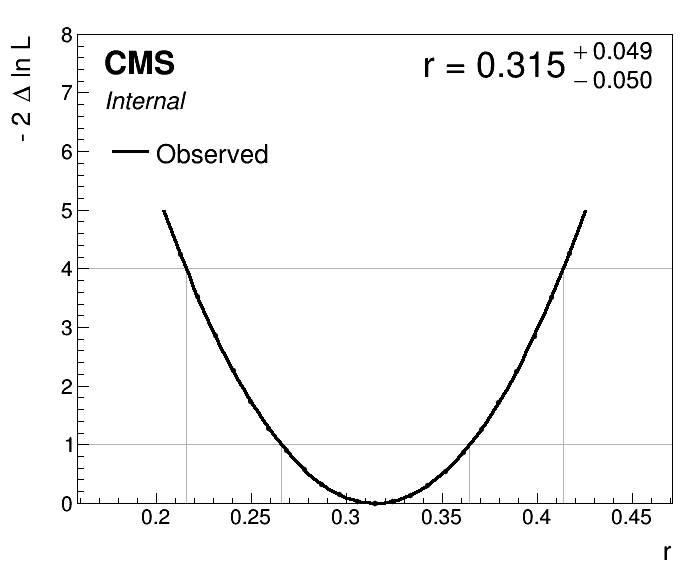

 <<< Combine >>> 
   Options for Robust Minimizer :: 
        Tolerance  0.1
        Strategy   0
        Type,Algo  Minuit2,Migrad
>>> method used is MultiDimFit
>>> random number generator seed is 123456
Set Default Value of Parameter r To : 0.29
Set Default Value of Parameter mask_AddTk_pm_mHad To : 1
Set Default Value of Parameter mask_B_pt To : 1
Set Default Value of Parameter mask_B_eta To : 1
Set Default Value of Parameter mask_Est_mu_q2bin0 To : 1
Set Default Value of Parameter mask_Est_mu_q2bin1 To : 1
Set Default Value of Parameter mask_Est_mu_q2bin2 To : 1
Set Default Value of Parameter mask_Est_mu_q2bin3 To : 1
Set Default Value of Parameter mask_M2_miss_q2bin0 To : 1
Set Default Value of Parameter mask_M2_miss_q2bin1 To : 1
Set Default Value of Parameter mask_M2_miss_q2bin2 To : 1
Set Default Value of Parameter mask_M2_miss_q2bin3 To : 1
Set Default Value of Parameter mask_Unrolled_q2bin2 To : 1
Set Default Value of Parameter mask_Unrolled_q2bin3 To : 1
>>> 13 out of 20 ch

Info in <TCanvas::Print>: pdf file ./scan.pdf has been created
Info in <TCanvas::Print>: png file ./scan.png has been created


In [71]:
if use_real_data:
    rDst_postFitRegion = [0.05, 0.7]
else:
    rDst_postFitRegion = [0.01, 0.6]

cmd = 'combine'
cmd += ' -M MultiDimFit'
cmd += ' --algo grid --points=70'
cmd += ' --robustFit 1'
cmd += ' -d ' + card_location.replace('.txt', '.root')
cmd += ' --X-rtd MINIMIZER_analytic'
cmd += ' --rMin={:.2f} --rMax={:.2f}'.format(*rDst_postFitRegion)
cmd += ' -n {}_preFitScan'.format(card_name)
cmd += ' --setParameters r={:.2f},{}'.format(SM_RDst, globalChannelMaskingStr)
cmd += ' --verbose -1'
print cmd
os.system(cmd)
cmd = 'plot1DScan.py higgsCombine{}_preFitScan.MultiDimFit.mH120.root'.format(card_name)
cmd += '; mv scan.png {}/scan_preFit.png'.format(outdir)
cmd += '; mv higgsCombine{}_preFitScan.MultiDimFit.mH120.root {}/'.format(card_name, outdir)
os.system(cmd)
res = getUncertaintyFromLimitTree(outdir+'/higgsCombine{}_preFitScan.MultiDimFit.mH120.root'.format(card_name))
rDst_postFitRegion = [res[0] - 3*res[1], res[0] + 3*res[2]]
fit_RDst = res[0]
display(Image(filename=outdir+'/scan_preFit.png'))

## Run the Maximum Likelyhood fit

In [72]:
seedMLf = '6741'
forceRDst = False

In [73]:
cmd = 'combine -M FitDiagnostics'
cmd += ' --robustFit 1 --robustHesse 1 --cminDefaultMinimizerStrategy 2 --X-rtd MINIMIZER_analytic'
cmd += ' --seed ' + seedMLf
cmd += ' -d ' + card_location.replace('.txt', '.root')
if forceRDst:
    cmd += ' --setParameterRanges r={:.2f},{:.2f}'.format(0, 1)  
    cmd += ' --customStartingPoint --setParameters r={:.3f}'.format(SM_RDst)
else:
    cmd += ' --skipBOnlyFit'
    cmd += ' --setParameterRanges r={:.2f},{:.2f}'.format(*rDst_postFitRegion)  
    cmd += ' --setParameters r={:.3f}'.format(fit_RDst)
if globalChannelMaskingStr:
    cmd += ',' + globalChannelMaskingStr
runName = card_name + ('_RDstFixed' if forceRDst else '')
cmd += ' -n ' + runName
cmd += ' --out ' + outdir
cmd += ' --saveShapes --saveWithUncertainties --saveNormalizations'
cmd += ' --trackParameters rgx{.*}'
cmd += ' --plots'
cmd += ' --verbose 0'

if runFitDiagnostics:
    print cmd
    status, output = commands.getstatusoutput(cmd)
    if status or 'There was a crash.' in output:
        print output
        raise
    for line in output.split('\n'):
            if 'ERROR' in line: print line.replace('ERROR', '\033[1m\x1b[31mError\x1b[0m')
            if line.startswith('customStartingPoint'): print line
    os.system('mv combine_logger.out ' + outdir + '/combine_logger_FitDiagnostics.out')
    os.system('mv ./higgsCombine{}.FitDiagnostics.mH120.{}.root '.format(runName, seedMLf) + outdir + '/');
    
    f = ur.open(glob(outdir + '/higgsCombine{}.FitDiagnostics.mH120.{}.root'.format(runName, seedMLf))[0])
    c, d, u, _ = f['limit']['limit'].array()
    print 'R(D*) = {:.3f} +{:.3f}/-{:.3f} [{:.1f} %]'.format(c, u-c, c-d, 100*(u-d)*0.5/c)

combine -M FitDiagnostics --robustFit 1 --robustHesse 1 --cminDefaultMinimizerStrategy 2 --X-rtd MINIMIZER_analytic --seed 6741 -d cards/v16low_CLN_blinded.root --skipBOnlyFit --setParameterRanges r=0.17,0.46 --setParameters r=0.315,mask_AddTk_pm_mHad=1,mask_B_pt=1,mask_B_eta=1,mask_Est_mu_q2bin0=1,mask_Est_mu_q2bin1=1,mask_Est_mu_q2bin2=1,mask_Est_mu_q2bin3=1,mask_M2_miss_q2bin0=1,mask_M2_miss_q2bin1=1,mask_M2_miss_q2bin2=1,mask_M2_miss_q2bin3=1,mask_Unrolled_q2bin2=1,mask_Unrolled_q2bin3=1 -n v16low_CLN_blinded --out results/v16low_CLN_blinded --saveShapes --saveWithUncertainties --saveNormalizations --trackParameters rgx{.*} --plots --verbose 0
R(D*) = 0.315 +0.145/-0.145 [46.0 %]


In [74]:
# Get post-fit shapes
n = outdir + '/fitDiagnostics{}.root'.format(card_name+ ('_RDstFixed' if forceRDst else ''))
print n
fFitDiagnostics = rt.TFile.Open(n, 'READ')
if forceRDst:
    fd = fFitDiagnostics.shapes_fit_b
else:
    fd = fFitDiagnostics.shapes_fit_s

if not 'histo' in vars().keys(): 
    histo = loadHisto4CombineFromRoot(histo_file_dir, card_name)
    
histo_postfit = {}
for regName in [k.GetTitle() for k in fd.GetListOfKeys()]:
    histo_postfit[regName] = {}
    
    for n, h in histo[regName].iteritems():
        if '__' in n: 
            continue
        h_post = h.Clone(h.GetName() + '_postfit')
        if 'data' in n:
            h_fit = fd.Get(regName+'/total')
            h_data = h.Clone(h.GetName() + '_data')
            for i in range(1, h_post.GetNbinsX()+1):
                h_post.SetBinContent(i, h_fit.GetBinContent(i))
                h_post.SetBinError(i, h_fit.GetBinError(i))     

            histo_postfit[regName]['total'] = h_post
            histo_postfit[regName]['data'] = h_data
        else:
            h_fit = fd.Get(regName+'/'+n)
            if not h_fit: 
                print n+' missing from '+regName
                continue
            for i in range(1, h_post.GetNbinsX()+1):
                h_post.SetBinContent(i, h_fit.GetBinContent(i))
                h_post.SetBinError(i, h_fit.GetBinError(i)) 

            histo_postfit[regName][n] = h_post

results/v16low_CLN_blinded/fitDiagnosticsv16low_CLN_blinded.root
AddTk_m_mHad 19861.0132408 19984.0
AddTk_mm_mHad 1015.6797533 1083.0
AddTk_p_mHad 39324.7738037 39010.0
AddTk_pm_mHad 7432.0442272 7300.0
AddTk_pm_mVis 7503.97206116 7482.0
BmDstmHc missing from AddTk_pp_mHad
AddTk_pp_mHad 1983.59931469 1988.0
B_eta 348484.427846 350314.0
B_pt 348484.428018 350314.0
Est_mu_q2bin0 68428.7288774 68730.0
Est_mu_q2bin1 141903.42303 141782.0
Est_mu_q2bin2 121389.139754 122965.0
Est_mu_q2bin3 16591.1420584 16837.0
M2_miss_q2bin0 68428.7274055 68730.0
M2_miss_q2bin1 141903.421289 141782.0
M2_miss_q2bin2 121389.14131 122965.0
M2_miss_q2bin3 16591.1425121 16837.0
Unrolled_q2bin0 67676.1025429 67893.0
Unrolled_q2bin1 140929.524744 140854.0
Unrolled_q2bin2 120599.587419 122160.0
Unrolled_q2bin3 16404.112828 16645.0


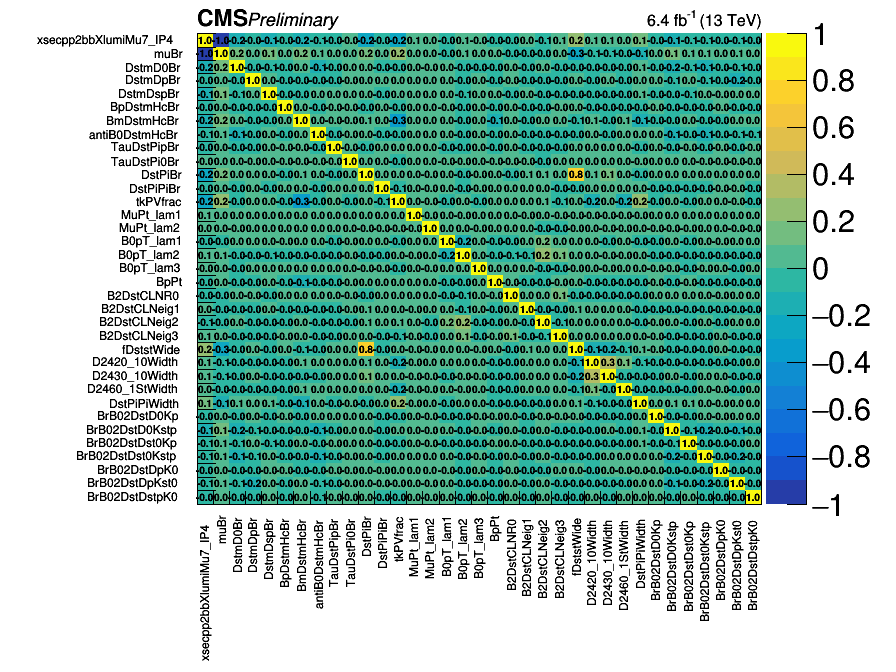

In [75]:
h2 = fFitDiagnostics.Get('covariance_fit_' + ('b' if forceRDst else 's'))
rt.gStyle.SetPaintTextFormat('.1f')

N = h2.GetNbinsX()
n=35

h2.GetXaxis().SetRange(1, n)
h2.GetYaxis().SetRangeUser(N-n, N)
h2.SetMarkerSize(.8)
h2.LabelsOption("v")
h2.GetXaxis().SetLabelSize(0.03)
h2.GetYaxis().SetLabelSize(0.03)
CC = drawOnCMSCanvas(CMS_lumi, [h2, h2], ['colz', 'text same'], size=(900, 700), tag='tl', mL=0.22, mR=0.15, mB=0.25)
CC.SaveAs(outdir+'/fig/covariance_zoom'+ ('_RDstFixed' if forceRDst else '')+'.png')

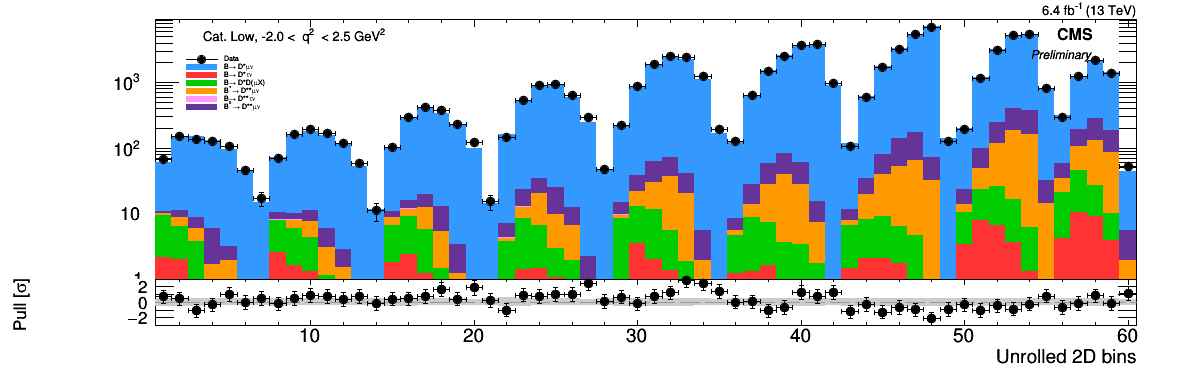

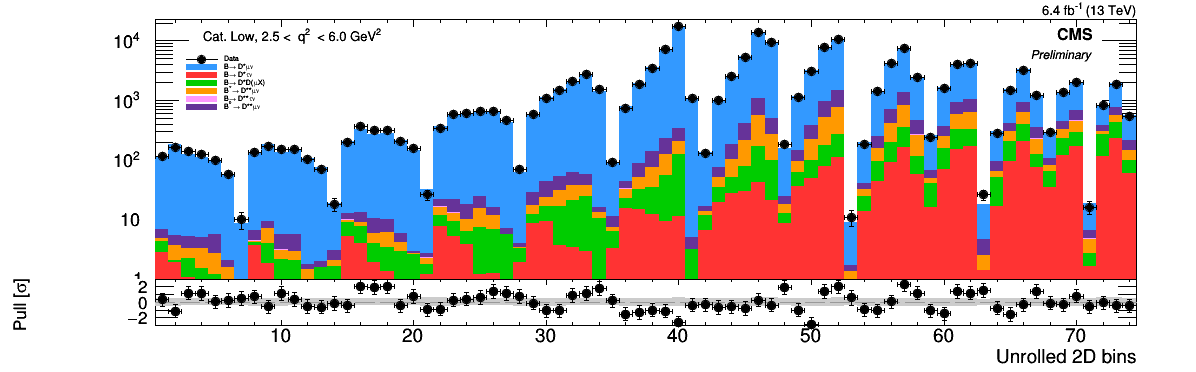

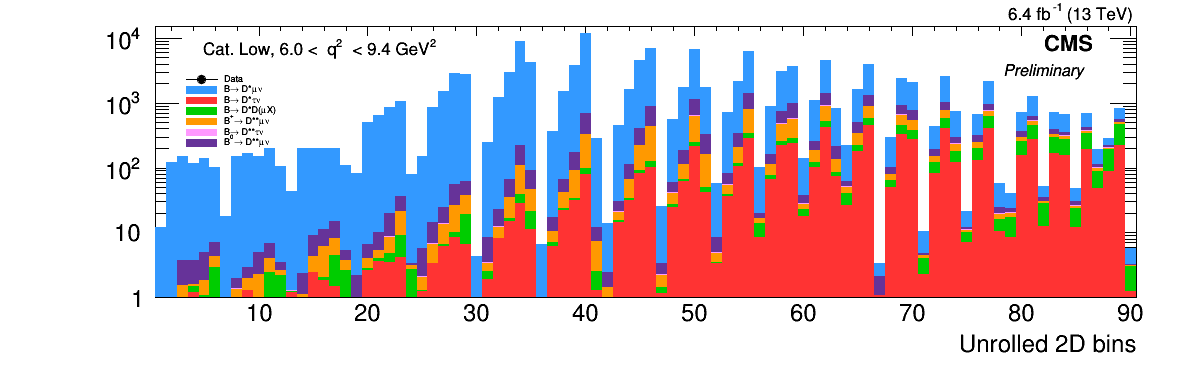

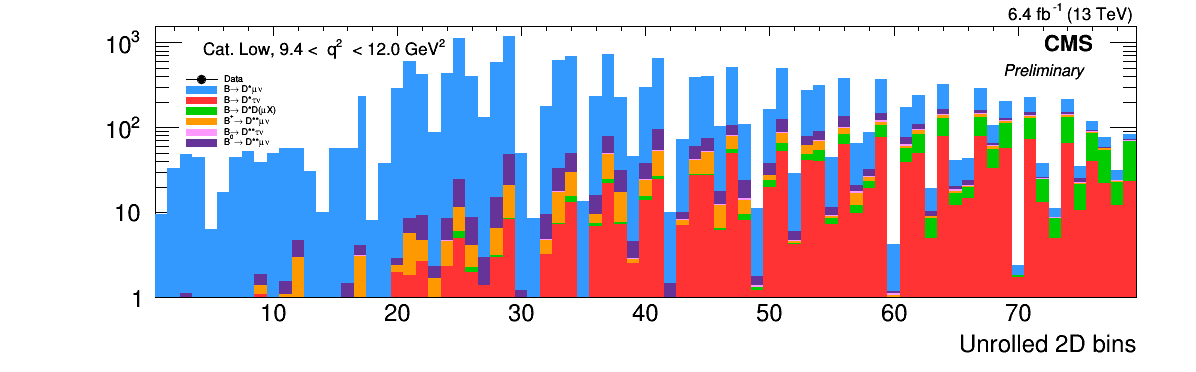

In [76]:
cUnrolledPost = []
for i_q2 in range(len(binning['q2'])-1):
    q2_l = binning['q2'][i_q2]
    q2_h = binning['q2'][i_q2 + 1]
    nameU = 'Unrolled_q2bin'+str(i_q2)
    histo_postfit[nameU]['data'].GetXaxis().SetTitle('Unrolled 2D bins')
    histo_postfit[nameU]['data'].GetYaxis().SetTitle('Events')
    cUnrolledPost.append(plot_SingleCategory(CMS_lumi, histo_postfit[nameU], draw_pulls=True, pullsRatio=False,
                                             addText='Cat. '+category.capitalize()+', {:.1f} <  q^{{2}}  < {:.1f} GeV^{{2}}'.format(q2_l, q2_h), 
                                             logy=True, legBkg=True,
                                             procOrder = ['tau', 'DstD', 'Dstst', 'mu'],
                                             min_y=1, 
                                             tag='Unrolled_q2bin'+str(i_q2), 
                                             legLoc=[0.15, 0.6, 0.3, 0.8],
                                             maskData = blinded_fit and (False if i_q2 < 2 else True),
                                             figsize = [1200, 400]
                                      ))
    n = outdir+'/fig/Unrolled_q2bin'+str(i_q2)+'_postfit'+ ('_RDstFixed' if forceRDst else '')+'.png'
    cUnrolledPost[i_q2].SaveAs(n)

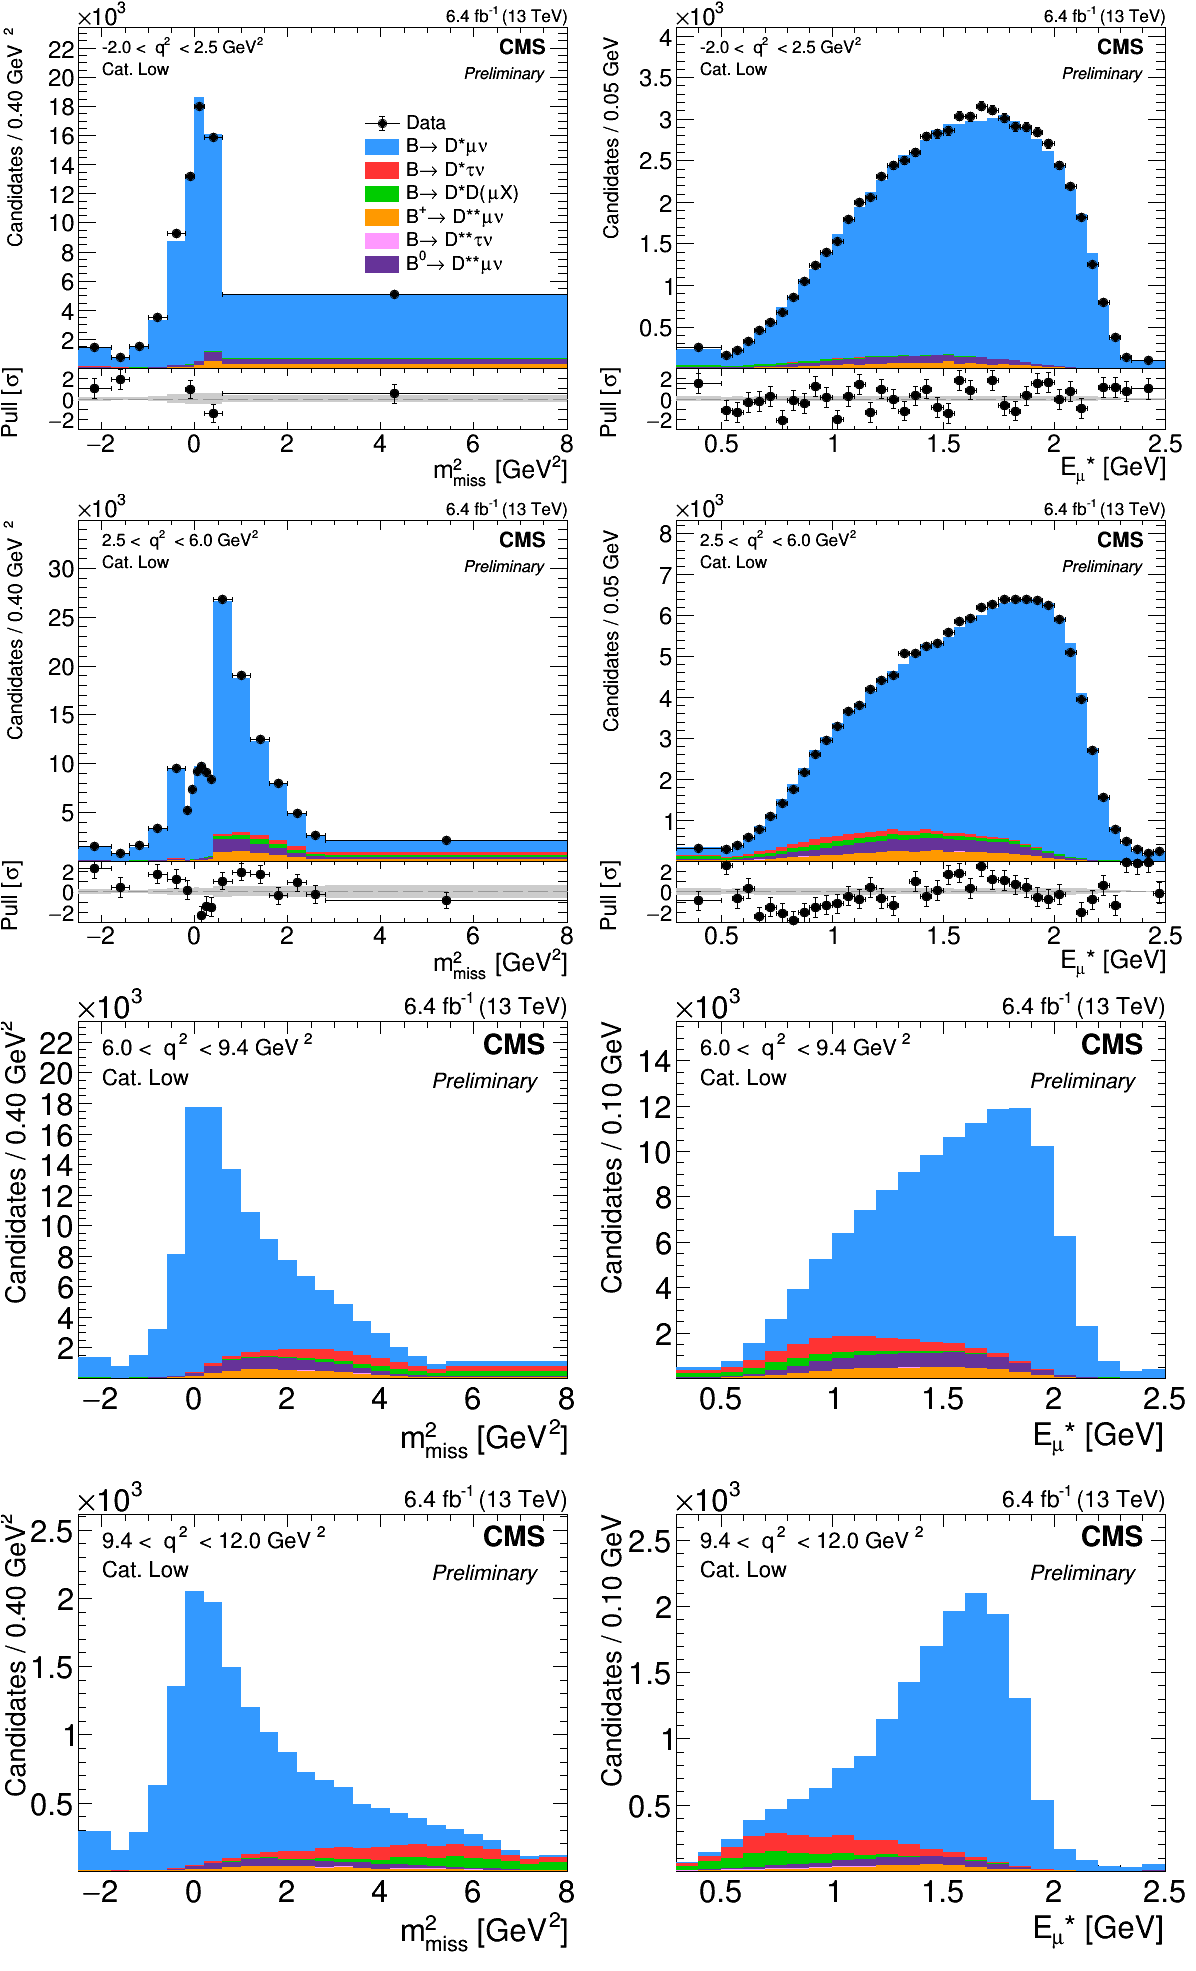

In [77]:
cSigPost = plot_gridVarQ2(CMS_lumi, binning, histo_postfit, draw_pulls=True, 
                          categoryText=cat.name.capitalize(),
                          iq2_maskData=[2, 3] if blinded_fit else [])
n = outdir+'/fig/signalRegion_postfit'+ ('_RDstFixed' if forceRDst else '')+'.png'
cSigPost.SaveAs(n)

In [78]:
if useMVA:
    cMVAPost = plot_SingleCategory(CMS_lumi, histo_postfit['MVA'], draw_pulls=True,
                                  addText='', logy=True, legBkg=True,
                                  procOrder = ['tau', 'DstD', 'Dstst', 'mu'],
                                  min_y=1, tag='MVA', legLoc=[0.2, 0.1, 0.4, 0.4])
    n = outdir+'/fig/MVA_postfit'+ ('_RDstFixed' if forceRDst else '')+'.png'
    cMVAPost.SaveAs(n)

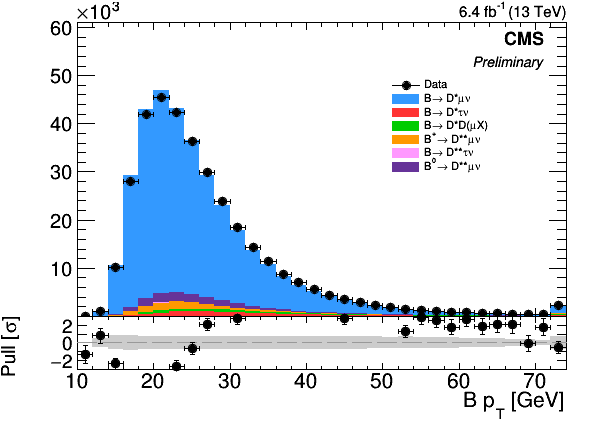

In [79]:
cB_pt_post = plot_SingleCategory(CMS_lumi, histo_postfit['B_pt'], draw_pulls=True,
                                 addText='', logy=False, legBkg=True,
                                 procOrder = ['tau', 'DstD', 'Dstst', 'mu'],
                                 min_y=1, tag='B_pt', legLoc=[0.65, 0.45, 0.9, 0.75])
n = outdir+'/fig/B_pt_postfit'+ ('_RDstFixed' if forceRDst else '')+'.png'
cB_pt_post.SaveAs(n)

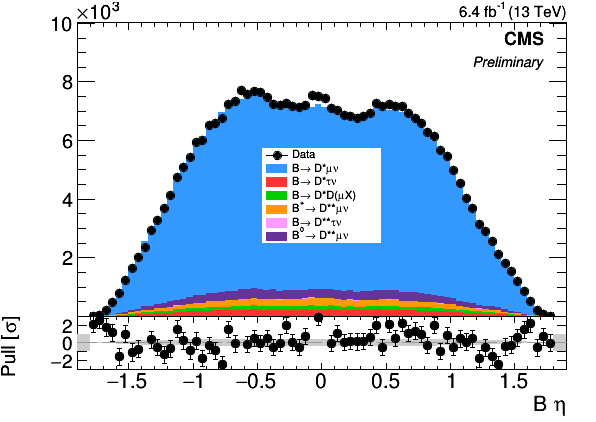

In [80]:
cB_eta_post = plot_SingleCategory(CMS_lumi, histo_postfit['B_eta'], draw_pulls=True,
                                  addText='', logy=False, legBkg=True,
                                  procOrder = ['tau', 'DstD', 'Dstst', 'mu'],
                                  min_y=1, tag='B_eta', legLoc=[0.44, 0.23, 0.64, 0.53])

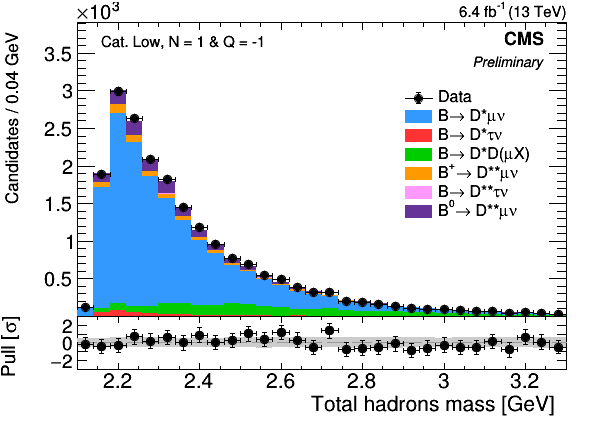

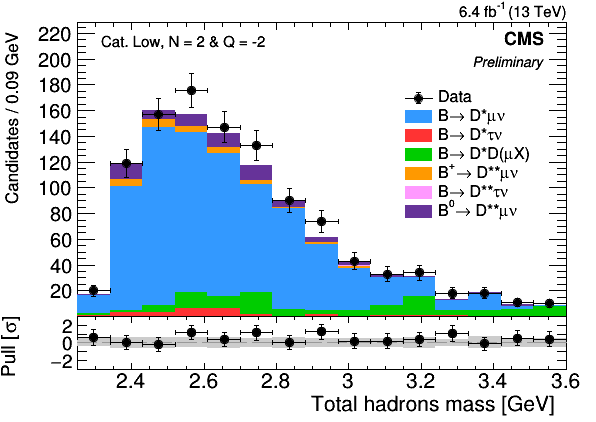

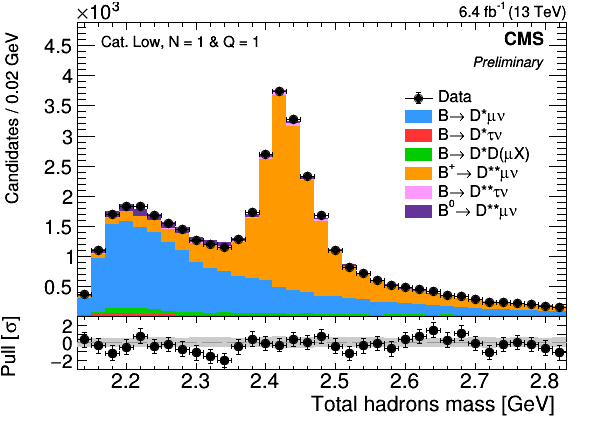

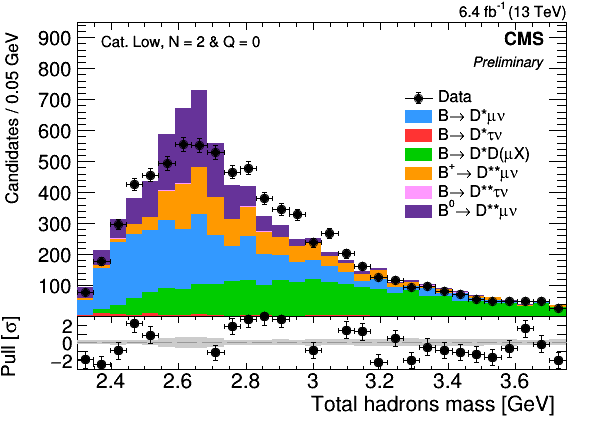

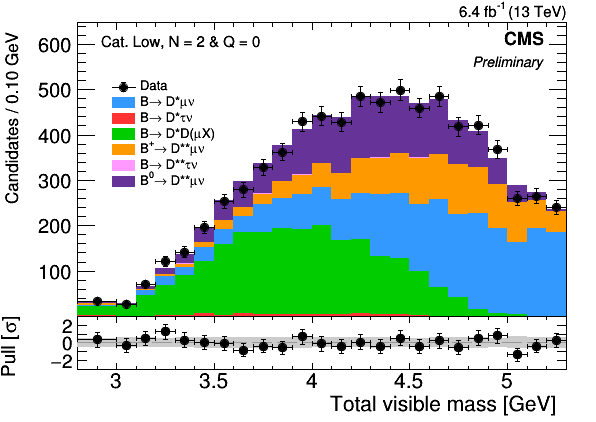

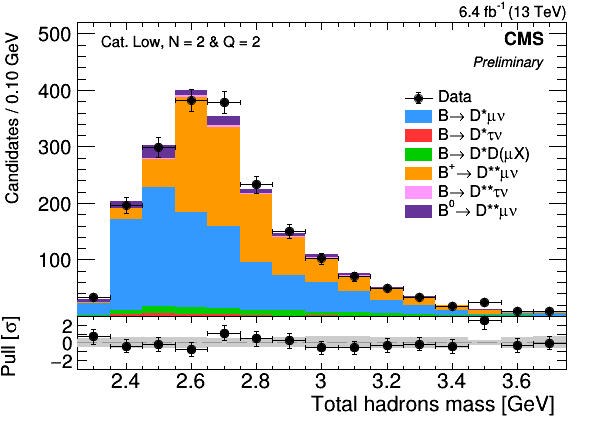

In [81]:
cSidePost = {}
for k in np.sort([k for k in histo.keys() if 'AddTk' in k]):
    legLoc = [0.67, 0.3, 0.93, 0.72]
    if 'Vis' in k:
        legLoc = [0.18, 0.4, 0.4, 0.75]
    cSidePost[k] = plot_SingleCategory(CMS_lumi, histo_postfit[k], 
                                       xtitle=getControlXtitle(k), 
                                       addText='Cat. '+cat.name.capitalize() + ', ' + getControlSideText(k),
                                       tag=k, legLoc=legLoc,
                                       draw_pulls=True
                                      )
    n = outdir+'/fig/'+k+'_postfit'+ ('_RDstFixed' if forceRDst else '')+'.png'
    cSidePost[k].SaveAs(n)

In [82]:
dumpDiffNuisances = dumpDiffNuisances

In [99]:
cmd = 'python diffNuisances.py '.format(os.environ['CMSSW_BASE'])
cmd += outdir + '/fitDiagnostics{}.root'.format(card_name+ ('_RDstFixed' if forceRDst else ''))
if not forceRDst:
    cmd += ' --skipFitB'
cmd += ' --all'
cmd += ' --abs'
cmd += ' -g {}/nuisance_difference'.format(outdir) + ('_RDstFixed' if forceRDst else '') + '.root'
print cmd
status, output = commands.getstatusoutput(cmd)
dumpDiffNuisances(output, outdir, tag='_RDstFixed' if forceRDst else '', 
                  useBonlyResults=forceRDst, parsToPrint=100)

python diffNuisances.py results/v16low_CLN_blinded/fitDiagnosticsv16low_CLN_blinded.root --skipFitB --all --abs -g results/v16low_CLN_blinded/nuisance_difference.root
+-----------------------+------------------------+-----------------------------------+
|       Parameter       |        pre-fit         |              post-fit             |
+-----------------------+------------------------+-----------------------------------+
|       B0pT_lam2       | 0.000000 +/- 1.000000  | !-4.14 +/- 0.80 (-4.14sig, 0.80)! |
|       B0pT_lam1       | 0.000000 +/- 1.000000  | !-3.83 +/- 0.88 (-3.83sig, 0.88)! |
|       BmDstmHcBr      |  0.000000 +/- 1.000000 | !+2.53 +/- 0.44 (+2.53sig, 0.44)! |
|     D2460_1StWidth    |  0.000000 +/- 1.000000 | !-2.27 +/- 0.51 (-2.27sig, 0.51)! |
|      B2DstCLNeig2     |  0.000000 +/- 1.000000 | !+2.07 +/- 0.85 (+2.07sig, 0.85)! |
|     D2430_10Width     | 0.000000 +/- 1.000000  | *+1.60 +/- 0.76 (+1.60sig, 0.76)* |
|        tkPVfrac       |  0.000000 +/- 1.000000 |

ValueError: could not convert string to float: *-1.96

## Run likelyhood scan

combine -M MultiDimFit --algo grid --points=100 --cminDefaultMinimizerStrategy=1 --robustFit 1 --X-rtd MINIMIZER_analytic -d cards/v16low_CLN_blinded.root --rMin=0.166 --rMax=0.463 -n v16low_CLN_blinded_nominal --setParameters r=0.32,mask_AddTk_pm_mHad=1,mask_B_pt=1,mask_B_eta=1,mask_Est_mu_q2bin0=1,mask_Est_mu_q2bin1=1,mask_Est_mu_q2bin2=1,mask_Est_mu_q2bin3=1,mask_M2_miss_q2bin0=1,mask_M2_miss_q2bin1=1,mask_M2_miss_q2bin2=1,mask_M2_miss_q2bin3=1,mask_Unrolled_q2bin2=1,mask_Unrolled_q2bin3=1 --verbose -1
plot1DScan.py higgsCombinev16low_CLN_blinded_nominal.MultiDimFit.mH120.root -o scan_nominal
----------------------------------
R(D*) = 0.315 +0.049/-0.050 [15.7 %]
Sigma = 0.049
----------------------------------



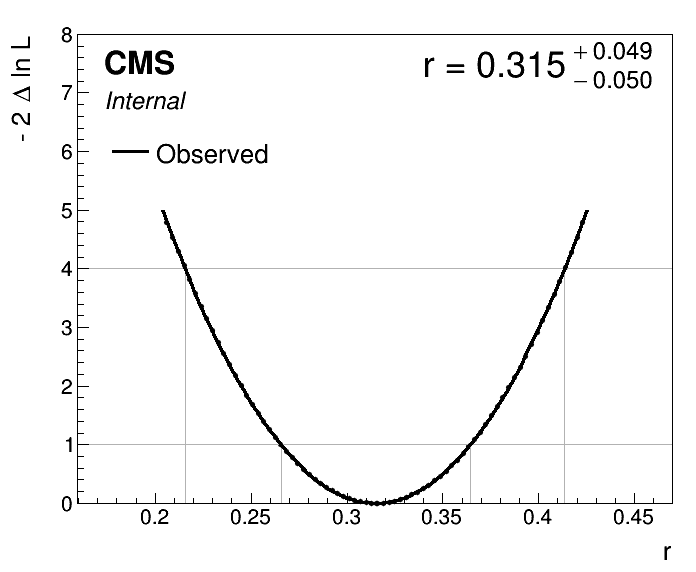

In [84]:
cmd = 'combine'
cmd += ' -M MultiDimFit'
cmd += ' --algo grid --points=100'
cmd += ' --cminDefaultMinimizerStrategy=1 --robustFit 1 --X-rtd MINIMIZER_analytic'
cmd += ' -d ' + card_location.replace('.txt', '.root')
cmd += ' --rMin={:.3f} --rMax={:.3f}'.format(*rDst_postFitRegion)
cmd += ' -n {}_nominal'.format(card_name)
cmd += ' --setParameters r={:.2f},{}'.format(fit_RDst, globalChannelMaskingStr)
cmd += ' --verbose -1'
print cmd
status, output = commands.getstatusoutput(cmd)
if status:
    print output
    raise
cmd = 'plot1DScan.py higgsCombine{}_nominal.MultiDimFit.mH120.root -o scan_nominal'.format(card_name)
print cmd
status, output = commands.getstatusoutput(cmd)
if status:
    print output
    raise
res_nominal = getUncertaintyFromLimitTree('higgsCombine{}_nominal.MultiDimFit.mH120.root'.format(card_name))
rDst_postFitRegion = [res_nominal[0] - 2.5*res_nominal[1], res_nominal[0] + 2.5*res_nominal[2]]
fit_RDst = res_nominal[0]
display(Image(filename='scan_nominal.png'))

### Uncertainy breakdown by group

In [85]:
cmd = 'combine -M MultiDimFit'
cmd += ' --cminDefaultMinimizerStrategy=1 --robustFit 1 --X-rtd MINIMIZER_analytic'
cmd += ' -d ' + card_location.replace('.txt', '.root')
cmd += ' --setParameters r={:.2f},{}'.format(fit_RDst, globalChannelMaskingStr)
cmd += ' --setParameterRanges r={:.3f},{:.3f}'.format(*rDst_postFitRegion)
cmd += ' -n {}_bestfit'.format(card_name)
cmd += ' --saveWorkspace --verbose -1'
print cmd
os.system(cmd);

combine -M MultiDimFit --cminDefaultMinimizerStrategy=1 --robustFit 1 --X-rtd MINIMIZER_analytic -d cards/v16low_CLN_blinded.root --setParameters r=0.32,mask_AddTk_pm_mHad=1,mask_B_pt=1,mask_B_eta=1,mask_Est_mu_q2bin0=1,mask_Est_mu_q2bin1=1,mask_Est_mu_q2bin2=1,mask_Est_mu_q2bin3=1,mask_M2_miss_q2bin0=1,mask_M2_miss_q2bin1=1,mask_M2_miss_q2bin2=1,mask_M2_miss_q2bin3=1,mask_Unrolled_q2bin2=1,mask_Unrolled_q2bin3=1 --setParameterRanges r=0.191,0.438 -n v16low_CLN_blinded_bestfit --saveWorkspace --verbose -1
 <<< Combine >>> 
   Options for Robust Minimizer :: 
        Tolerance  0.1
        Strategy   0
        Type,Algo  Minuit2,Migrad
>>> method used is MultiDimFit
>>> random number generator seed is 123456
Set Range of Parameter r To : (0.191,0.438)
Set Default Value of Parameter r To : 0.32
Set Default Value of Parameter mask_AddTk_pm_mHad To : 1
Set Default Value of Parameter mask_B_pt To : 1
Set Default Value of Parameter mask_B_eta To : 1
Set Default Value of Parameter mask_Est_mu

In [86]:
# Statistical uncertainty
cmd = 'combine -M MultiDimFit --algo grid --points=100'
cmd += ' --cminDefaultMinimizerStrategy=1 --robustFit 1 --X-rtd MINIMIZER_analytic'
cmd += ' -d higgsCombine{}_bestfit.MultiDimFit.mH120.root'.format(card_name)
cmd += ' --snapshotName MultiDimFit'
cmd += ' --rMin={:.3f} --rMax={:.3f}'.format(*rDst_postFitRegion)
cmd += ' -n {}_stat'.format(card_name)
cmd += ' --freezeParameters allConstrainedNuisances'
cmd += ' --setParameters ' + globalChannelMaskingStr
cmd += ' --fastScan' # To be added if there are no free parameters otherwise
cmd += ' --verbose -1'
print cmd
os.system(cmd);

combine -M MultiDimFit --algo grid --points=100 --cminDefaultMinimizerStrategy=1 --robustFit 1 --X-rtd MINIMIZER_analytic -d higgsCombinev16low_CLN_blinded_bestfit.MultiDimFit.mH120.root --snapshotName MultiDimFit --rMin=0.191 --rMax=0.438 -n v16low_CLN_blinded_stat --freezeParameters allConstrainedNuisances --setParameters mask_AddTk_pm_mHad=1,mask_B_pt=1,mask_B_eta=1,mask_Est_mu_q2bin0=1,mask_Est_mu_q2bin1=1,mask_Est_mu_q2bin2=1,mask_Est_mu_q2bin3=1,mask_M2_miss_q2bin0=1,mask_M2_miss_q2bin1=1,mask_M2_miss_q2bin2=1,mask_M2_miss_q2bin3=1,mask_Unrolled_q2bin2=1,mask_Unrolled_q2bin3=1 --fastScan --verbose -1
 <<< Combine >>> 
   Options for Robust Minimizer :: 
        Tolerance  0.1
        Strategy   0
        Type,Algo  Minuit2,Migrad
>>> method used is MultiDimFit
>>> random number generator seed is 123456
Set Default Value of Parameter mask_AddTk_pm_mHad To : 1
Set Default Value of Parameter mask_B_pt To : 1
Set Default Value of Parameter mask_B_eta To : 1
Set Default Value of Param

In [87]:
n = 'higgsCombine{}_stat.MultiDimFit.mH120.root'.format(card_name)
getUncertaintyFromLimitTree(n);

----------------------------------
R(D*) = 0.315 +0.026/-0.026 [8.1 %]
Sigma = 0.026
----------------------------------



In [88]:
# MC Statistics
cmd = 'combine -M MultiDimFit --algo grid --points=100'
cmd += ' --cminDefaultMinimizerStrategy=2 --robustFit 1 --X-rtd MINIMIZER_analytic'
cmd += ' -d higgsCombine{}_bestfit.MultiDimFit.mH120.root'.format(card_name)
cmd += ' --rMin={:.4f} --rMax={:.4f}'.format(*rDst_postFitRegion)
cmd += ' -n {}_MCstat'.format(card_name)
cmd += ' --snapshotName MultiDimFit'
cmd += ' --setParameters ' + globalChannelMaskingStr
cmd += ' --freezeNuisanceGroups=autoMCStats'
cmd += ' --verbose -1'
print cmd
os.system(cmd);

combine -M MultiDimFit --algo grid --points=100 --cminDefaultMinimizerStrategy=2 --robustFit 1 --X-rtd MINIMIZER_analytic -d higgsCombinev16low_CLN_blinded_bestfit.MultiDimFit.mH120.root --rMin=0.1912 --rMax=0.4384 -n v16low_CLN_blinded_MCstat --snapshotName MultiDimFit --setParameters mask_AddTk_pm_mHad=1,mask_B_pt=1,mask_B_eta=1,mask_Est_mu_q2bin0=1,mask_Est_mu_q2bin1=1,mask_Est_mu_q2bin2=1,mask_Est_mu_q2bin3=1,mask_M2_miss_q2bin0=1,mask_M2_miss_q2bin1=1,mask_M2_miss_q2bin2=1,mask_M2_miss_q2bin3=1,mask_Unrolled_q2bin2=1,mask_Unrolled_q2bin3=1 --freezeNuisanceGroups=autoMCStats --verbose -1
 <<< Combine >>> 
   Options for Robust Minimizer :: 
        Tolerance  0.1
        Strategy   0
        Type,Algo  Minuit2,Migrad
>>> method used is MultiDimFit
>>> random number generator seed is 123456
Set Default Value of Parameter mask_AddTk_pm_mHad To : 1
Set Default Value of Parameter mask_B_pt To : 1
Set Default Value of Parameter mask_B_eta To : 1
Set Default Value of Parameter mask_Est_m

In [89]:
n = 'higgsCombine{}_MCstat.MultiDimFit.mH120.root'.format(card_name)
getUncertaintyFromLimitTree(n);

----------------------------------
R(D*) = 0.315 +0.043/-0.043 [13.7 %]
Sigma = 0.043
----------------------------------



plot1DScan.py higgsCombinev16low_CLN_blinded_nominal.MultiDimFit.mH120.root --main-label "Obs. Low (blinded)" --others "higgsCombinev16low_CLN_blinded_MCstat.MultiDimFit.mH120.root:Stat. + Syst.:4" "higgsCombinev16low_CLN_blinded_stat.MultiDimFit.mH120.root:Stat. only:2" --breakdown "MC stat.,syst.,stat." --translate results/v16low_CLN_blinded/renameDicLikelihoodScan.json; mv scan.png scan_breakdown.png


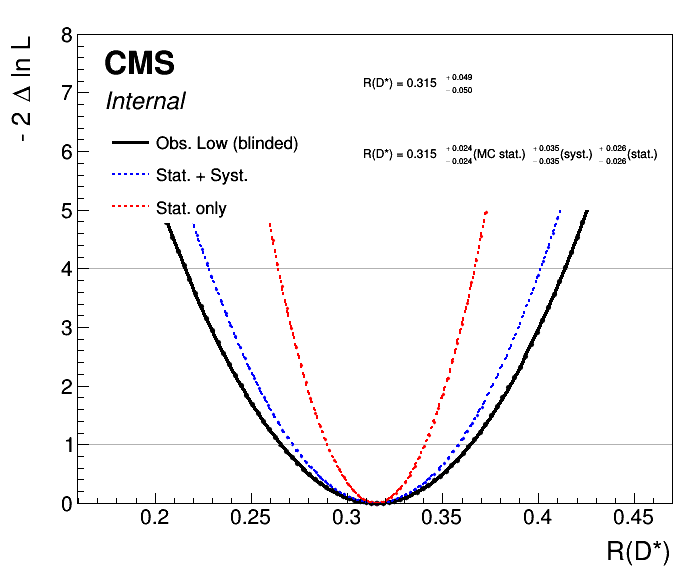

--------------------------------------
scan
--------------------------------------
[{'lo': 0.26556984958373964, 'hi': 0.36446201684376933, 'valid_hi': True, 'valid_lo': True}]
[{'lo': 0.21561915961962522, 'hi': 0.41362116244865066, 'valid_hi': True, 'valid_lo': True}]
[{'lo': 0.2717624870060103, 'hi': 0.35831702907136465, 'valid_hi': True, 'valid_lo': True}]
[{'lo': 0.2280767611091512, 'hi': 0.40126446694482604, 'valid_hi': True, 'valid_lo': True}]
[{'lo': 0.2897680006640489, 'hi': 0.3409295054769078, 'valid_hi': True, 'valid_lo': True}]
[{'lo': 0.2643492163668968, 'hi': 0.3666715408016693, 'valid_hi': True, 'valid_lo': True}]


Info in <TCanvas::Print>: pdf file ./scan.pdf has been created
Info in <TCanvas::Print>: png file ./scan.png has been created


In [90]:
json.dump({'r': 'R(D*)'}, open(outdir+'/renameDicLikelihoodScan.json', 'w'))

cmd = 'plot1DScan.py higgsCombine{}_nominal.MultiDimFit.mH120.root'.format(card_name)
cmd += ' --main-label "{} {}'.format('Obs.' if use_real_data else 'Asimov', category.capitalize())
if blinded_fit: cmd += ' (blinded)'
cmd += '"'
cmd += ' --others'
cmd += ' "higgsCombine{}_MCstat.MultiDimFit.mH120.root:Stat. + Syst.:4"'.format(card_name)
cmd += ' "higgsCombine{}_stat.MultiDimFit.mH120.root:Stat. only:2"'.format(card_name)
cmd += ' --breakdown "MC stat.,syst.,stat."'
cmd += ' --translate ' + outdir+'/renameDicLikelihoodScan.json'
cmd += '; mv scan.png scan_breakdown.png'
print cmd
os.system(cmd)
display(Image(filename='scan_breakdown.png'))

In [91]:
os.system('mv higgsCombine{}_*.MultiDimFit.mH120.root '.format(card_name) + outdir + '/')
os.system('mv scan* ' + outdir + '/')
os.system('mv combine_logger.out ' + outdir + '/');

## Run the impact plots

Fit first the POI

In [92]:
if not os.path.isdir(outdir+'/impactPlots'): os.mkdir(outdir+'/impactPlots')

In [93]:
cmd = 'cd {}/impactPlots;'.format(outdir)
cmd += ' combineTool.py -M Impacts --doInitialFit -m 120'
cmd += ' --robustFit 1 --X-rtd MINIMIZER_analytic'
cmd += ' -d ../../../' + card_location.replace('.txt', '.root')
cmd += ' -D ' + histo[histo.keys()[0]]['data'].GetName()
cmd += ' --setParameters r={:.2f},{}'.format(SM_RDst, globalChannelMaskingStr)
cmd += ' --setParameterRanges r=0.05,1'
cmd += ' -n {}'.format(card_name)
cmd += ' --verbose -1'
if runImpacts: os.system(cmd);

 Perform a similar scan for each nuisance parameter

If running on Tier2 condor remmeber to add this line to CombineToolBase.py ln 11
``source /cvmfs/cms.cern.ch/cmsset_default.sh``

In [94]:
cmd = 'cd {}/impactPlots;'.format(outdir)
cmd += ' combineTool.py -M Impacts --doFits -m 120'
cmd += ' --robustFit 1 --X-rtd MINIMIZER_analytic'
cmd += ' --parallel 100 --job-mode condor --task-name combineImpacts_'+category
cmd += ' --sub-opts "{}"'.format(stringJubCustomizationCaltechT2.replace('"', '\\\"').replace('$', '\$'))
cmd += ' -d ../../../' + card_location.replace('.txt', '.root')
cmd += ' -D ' + histo[histo.keys()[0]]['data'].GetName()
cmd += ' -n {}'.format(card_name)
cmd += ' --setParameters ' + globalChannelMaskingStr 
cmd += ' --verbose -1'
print cmd
if runImpacts: os.system(cmd);

cd results/v16low_CLN_blinded/impactPlots; combineTool.py -M Impacts --doFits -m 120 --robustFit 1 --X-rtd MINIMIZER_analytic --parallel 100 --job-mode condor --task-name combineImpacts_low --sub-opts "
+RunAsOwner = True
+InteractiveUser = True
+SingularityImage = \"/cvmfs/singularity.opensciencegrid.org/cmssw/cms:rhel7-m20200605\"
+SingularityBindCVMFS = True
+MaxRuntime = 3600
RequestDisk = 200000
RequestMemory = 2500
RequestCpus = 1
x509userproxy = \$ENV(X509_USER_PROXY)
" -d ../../../cards/v16low_CLN_blinded.root -D data_obs -n v16low_CLN_blinded --setParameters mask_AddTk_pm_mHad=1,mask_B_pt=1,mask_B_eta=1,mask_Est_mu_q2bin0=1,mask_Est_mu_q2bin1=1,mask_Est_mu_q2bin2=1,mask_Est_mu_q2bin3=1,mask_M2_miss_q2bin0=1,mask_M2_miss_q2bin1=1,mask_M2_miss_q2bin2=1,mask_M2_miss_q2bin3=1,mask_Unrolled_q2bin2=1,mask_Unrolled_q2bin3=1 --verbose -1


Collect the results

In [95]:
status, output = commands.getstatusoutput('condor_q')
while runImpacts and ('combineImpacts_'+category in output):
    time.sleep(20)
    status, output = commands.getstatusoutput('condor_q')
    for l in output.split('\n'):
        if 'combineImpacts_'+category in l: 
            print l
            sys.stdout.flush()
cmd = 'cd {}/impactPlots;'.format(outdir)
cmd += ' combineTool.py -M Impacts -o impacts.json -m 120'
cmd += ' -d ../../../' + card_location.replace('.txt', '.root')
cmd += ' -n {}'.format(card_name)
print cmd
if runImpacts: os.system(cmd);

cd results/v16low_CLN_blinded/impactPlots; combineTool.py -M Impacts -o impacts.json -m 120 -d ../../../cards/v16low_CLN_blinded.root -n v16low_CLN_blinded


In [96]:
rename = {
'r': 'R(D*)',
'B0pT': 'B_{0} p_{T} spectrum',
'B2DstCLNR0':'R_{0} (CLN B#rightarrow D*l#nu)',
'B2DstCLNeig1':'#lambda_{1} (CLN B#rightarrow D*l#nu)',
'B2DstCLNeig2':'#lambda_{2} (CLN B#rightarrow D*l#nu)',
'B2DstCLNeig3':'#lambda_{3} (CLN B#rightarrow D*l#nu)',
'trgSF': 'Trigger scale factor',
'xsecpp2bbXlumi': 'Luminosity*#sigma_{pp#rightarrowbb}',
}
for i in range(1,5):
    s = str(i)
    rename['B0pT_lam'+s] = 'B_{0} p_{T} #lambda_{'+s+'}'

procName_dic = {
'mu'        : 'B_{0}#rightarrow D*#mu#nu',
'tau'       : 'B_{0}#rightarrow D*#tau#nu',
'DstmD0'    : 'B^{+}#rightarrow D*D_{0}(#muY) + X',
'DstmDp'    : 'B^{+}#rightarrow D*D^{+}(#muY) + X',
'DstmDsp'   : 'B^{+}#rightarrow D*D_{s}^{+}(#muX)',
'DstPip'    : 'B^{+}#rightarrow D*#pi^{+}#mu#nu',
'DstPipPi0' : 'B^{+}#rightarrow D*#pi^{+}#pi^{0}#mu#nu',
'DstPi0'    : 'B_{0}#rightarrow D*#pi^{0}#mu#nu',
'DstPipPim' : 'B_{0}#rightarrow D*#pi^{+}#pi^{-}#mu#nu',
'DstPi0Pi0' : 'B_{0}#rightarrow D*#pi^{0}#pi^{0}#mu#nu',
'BpDstmHc'  : 'B^{+}#rightarrow D*D(#muX)',
'BmDstmHc'  : 'B^{-}#rightarrow D*D(#muX)',
'antiB0DstmHc'  : '#bar{B}_{0}#rightarrow D*D(#muX)',
'DstPi'     : 'B #rightarrow D**(#rightarrow D*#pi)#mu#nu',
'DstPiPi'   : 'B #rightarrow D**(#rightarrow D*#pi#pi)#mu#nu',
}

for n in procName_dic:
    rename[n+'Br'] = 'Branching fraction ' + procName_dic[n]
    
if runImpacts: 
    d = json.load(open(outdir+'/impactPlots/impacts.json', 'r'))
    for par in d['params']:
        name = str(par['name'])
        if not name.startswith('prop_bin'): continue
        label = name.replace('prop_bin', 'MC stat. ')
        label = label.replace('M2_miss_', 'M^{2}_{miss} ')
        label = label.replace('Est_mu_', 'E*_{#mu} ')
        label = label.replace('q2bin', '[b_{q^{2}}=')
        label = label.replace('_bin', '] ')
        rename[name] = label + 10*' '

    json.dump(rename, open(outdir+'/impactPlots/rename.json', 'w'))

    cmd = 'cd {};'.format(outdir)
    cmd += 'plotImpacts.py -i impactPlots/impacts.json -o impacts -t impactPlots/rename.json'
    os.system(cmd)
    IFrame(outdir+'/impacts.pdf', width=900, height=600)

## Run the Goodness of fit test

In [97]:
if not runGoF: raise

TypeError: exceptions must be old-style classes or derived from BaseException, not NoneType

Run the observed test stat value

In [ ]:
GoF_AdditionalChannelMasking = [
#     'AddTk_p_mHad',
#     'AddTk_m_mHad',
#     'AddTk_pm_mVis',
#     'AddTk_pp_mHad',
#     'AddTk_mm_mHad',
#     'Unrolled_q2bin0',
#     'Unrolled_q2bin1',
#     'Unrolled_q2bin2',
#     'Unrolled_q2bin3', 
#     'Est_mu_q2bin0',
#     'Est_mu_q2bin1',
#     'Est_mu_q2bin2',
#     'Est_mu_q2bin3',
#     'M2_miss_q2bin0',
#     'M2_miss_q2bin1',
#     'M2_miss_q2bin2',
#     'M2_miss_q2bin3',
#     'MVA',
#     'AddTk_pm_mHad',
]

maskGoF = globalChannelMaskingStr
for c in GoF_AdditionalChannelMasking:
    maskGoF += ',mask_'+c+'=1'
tag = '_All'
# tag = '_SignalRegionOnly'
# tag = '_ControlRegionOnly'
# tag = '_AddTk_pp_mHad_Only'

algo = ['Sat', 'AD', 'KS'][2]
fixRDst = False
fitRegionsOnly = False

tag += '_algo'+algo
if fixRDst:
    tag += '_fixRDst'
if fitRegionsOnly or algo!='Sat':
    tag += '_fitRegionsOnly'
    
os.system('rm -rf *.GoodnessOfFit.*.root')
print tag

In [ ]:
cmd = 'combine -M GoodnessOfFit'
cmd += ' --algo=saturated  --toysFrequentist' if algo=='Sat' else ' --algo=AD'
cmd += ' --X-rtd MINIMIZER_analytic  --cminDefaultMinimizerStrategy=1'
if not fitRegionsOnly:
    cmd += ' --setParametersForFit ' + globalChannelMaskingStr
    cmd += ' --setParametersForEval ' + maskGoF
if fixRDst or fitRegionsOnly:
    aux = card_location.replace('.txt', '.root')
    if fitRegionsOnly:
        aux = aux.replace('.root', '_fitRegionsOnly.root')
    cmd += ' -d ' + aux
    cmd += ' --freezeParameters r --setParameters r={:.3f}'.format(SM_RDst, maskGoF)
else:
    cmd += ' -d results/{cn}/higgsCombine{cn}_bestfit.MultiDimFit.mH120.root'.format(cn=card_name)
    cmd += ' --snapshotName MultiDimFit'
cmd += ' -n Obs'+tag
cmd += ' -t 0 -s 100'
cmd += ' --verbose -1'
print cmd
status, output = commands.getstatusoutput(cmd)
print output

Run the test stat toy distribution

In [ ]:
cmdToys = cmd.replace('-n Obs', '-n Toys')
cmdToys = cmdToys.replace('-t 0 -s 100', '-t 20 -s -1')
print cmdToys

In [ ]:
from multiprocessing import Pool

def runCommand(cmd):
    status, output = commands.getstatusoutput(cmd)
    return [status, output]

Nrep = 15
p = Pool(min(20,Nrep))
outputs = p.map(runCommand, Nrep*[cmdToys])
for s,o in outputs:
    if s: print o

In [ ]:
gofOutdir = outdir + '/goodnessOfFit'+tag

if os.path.isdir(gofOutdir):
    os.system('rm -rf ' + gofOutdir)
    
if not os.path.isdir(gofOutdir):
    os.system('mkdir ' + gofOutdir)

os.system('mv *.root {}/'.format(gofOutdir));

Combine them to get the p-value

In [ ]:
f = ur.open(gofOutdir+'/higgsCombineObs'+tag+'.GoodnessOfFit.mH120.100.root')
s_obs = f['limit']['limit'].array()[0]

s_toys = []
for name_toys in glob(gofOutdir+'/higgsCombineToys'+tag+'.GoodnessOfFit.*.root'):
    f = ur.open(name_toys)
    s_toys += list(f['limit']['limit'].array())
p_val = np.sum(s_toys > s_obs)/float(len(s_toys))

plt.rcParams.update({'font.size': 18})
fig = plt.figure(figsize=(8,6))
content, center, _ = plt.hist(s_toys, weights=np.ones_like(s_toys)/float(len(s_toys)), 
                              alpha=0.7, label='Toys ({:.0f})'.format(float(len(s_toys))))
plt.plot([s_obs, s_obs], [0, np.max(content)], 'm--', label='Observed\np-val {:.1f}%'.format(100*p_val))
plt.legend(loc='upper right')
plt.xlabel('Test statistic')
plt.ylabel('Probability / {:.1f}'.format(0.5*(center[2]-center[1])))
plt.savefig(outdir + '/fig/GoF_results'+tag+'.png')

In [ ]:
strRes = tag[1:]
strRes += ' '*(55-len(strRes))
strRes += '{:.1f}'.format(s_obs)
strRes += ' '*(70-len(strRes))
strRes += '{:.1f}\t{:.1f}'.format(np.percentile(s_toys, 50), np.percentile(s_toys, 95))
os.system('echo "{}" >> {}/GoF_results.txt'.format(strRes, outdir));

# The end

In [ ]:
print 'Done'